# Исследование данных фермера для покупок бурёнок

**Цель исследования** - разработать модель машинного обучения, которая поможет управлять рисками и принимать объективное решение о покупке коров. 

**Задачи:**

Разработать модель машинного обучения, которая поможет принять выбор о покупке коров.
- Необходимо спрогнозировать удой коров
- Необходимо спрогнозировать вкус молока

**План исследования**
1. Изучить данные;
2. Предобработка данных;
3. Исследовательский анализ данных
4. Корреляционный анализ
5. Обучение модели 
6. Сделать общий вывод исследования 

**Согласно документации к данным**

Таблица `ferma_main` содержит данные о стаде фермера на текущий момент:

- `id` — уникальный идентификатор коровы.
- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
- `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Жирность,%` — содержание жиров в молоке (в процентах).
- `Белок,%` — содержание белков в молоке (в процентах).
- `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Таблица `ferma_dad` содержит имя папы каждой коровы в стаде фермера:

- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.

Таблица `cow_buy` содержит данные о коровах «ЭкоФермы»:

- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

# Изучение данных.

## Импорт библиотек

In [1]:
import os
import warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Импорт модуля stats библиотеки scipy
import scipy.stats as st

# Импортируем модули для машинного обучения
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

# Импортируем метрики для оценки качества модели
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score
)

# Импортируем сторонние библиотеки
import phik 
from phik.report import plot_correlation_matrix

## Функции

In [2]:
def linear_regres(X, y, cat_col_names, num_col_names, RANDOM_STATE):
    '''
    Функция принимает значение входных признаков, целевого признака,
    название категориальных и количественных столбцов и константу. Подготавливает 
    данные для машинного обучения и обучает модель линейной регрессии. 
    Выводит метрики оценки модели, то есть коэффициент детерминации,
    среднюю абсолютную ошибку, средне квадратичную ошибку и корень 
    средне квадратичной ошибки, доверительный интервал прогноза,
    а также графики остатков и обученую модель.

    '''

    # Разделяем данные на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE)

    # Подготовка признаков для масштабирования и кодирования
    # Создаем переменную с экземпляром класса StandardScaler
    scaler = StandardScaler()

    # Обучаем и трансформируем количественные признаки из тренировчнй выборки
    # и преобразуем количественные признаки в тестовой выборке
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    # Создаем переменную с экземпляром класса OneHotEncoder с избеганием дамми-ошибок
    encoder = OneHotEncoder(drop='first', sparse=False)

    # Обучаем и трансформируем категориальные признаки из тренировчнй выборки
    # и преобразуем категориальные признаки в тестовой выборке
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])

    # Получаем список новых столбцов и сохраняем его в новой переменой
    encoder_col_names = encoder.get_feature_names_out()

    # Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    # Объединяем все преобразованные данные
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    # Обучение модели и получение предсказаний на тестовых данных
    model_lr = OneVsRestClassifier(LinearRegression())
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)

    # Рассчитываем остатки и коэффициент детерминации
    residuals = y_test - predictions

    r2 = r2_score(y_test, predictions)

    # Расчитываем среднюю абсолютную ошибку
    mae = mean_absolute_error(y_test, predictions)

    # Расчитываем среднеквадратичную ошибку
    mse = mean_squared_error(y_test, predictions)

    # Расчитываем корень среднеквадратичной ошибки
    rmse = mean_squared_error(y_test, predictions, squared=False)

    # Расчитаем доверительный интервал прогноза
    conf_int = st.norm.interval(0.95, loc=np.mean(
        predictions), scale=st.sem(predictions))

    # Выводим метрики и доверительный интервал
    print("Коэффициент детерминации =", r2)
    print("Средняя абсолютная ошибка =", mae)
    print("Среднеквадратичная ошибка =", mse)
    print("Корень среднеквадратичной ошибки =", rmse)
    print('Доверительный интервал =', conf_int)

    # Строим графики по количественным признакам — гистограмму частотности
    # распределения и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x=predictions, y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

    # Выводим нашу обученую модель
    return model_lr, scaler, encoder

In [3]:
def fat_content(df):
    '''
    Функция преобразует колличественный
    признак в котегориальный признак
    
    '''

    if df < 3.45:
        return 'Низкая'
    elif df > 3.68:
        return 'Высокая'
    else:
        return 'Средняя'

## Константы

In [4]:
# Задаем константу для деления датасета на одинаковые выборки
RANDOM_STATE = 42

## Загрузка данных

Прочитаем файлы `ferma_main.csv`, `ferma_dad.csv` и  `cow_buy.csv` и сохраним их в переменные `ferma_main`, `ferma_dad` и `cow_buy`.

In [5]:
pth1 = r"C:\Users\stepa\Downloads\ferma_main.csv"
pth2 = r"C:\Users\stepa\Downloads\ferma_dad.csv"
pth3 = r"C:\Users\stepa\Downloads\cow_buy.csv"

In [6]:
if os.path.exists(pth1):
    ferma_main = pd.read_csv(pth1, sep=';')
else:
    print('Ошибка')

In [7]:
if os.path.exists(pth2):
    ferma_dad = pd.read_csv(pth2, sep=';')
else:
    print('Ошибка')

In [8]:
if os.path.exists(pth3):
    cow_buy = pd.read_csv(pth3, sep=';')
else:
    print('Ошибка')

Выведем первые 5 строк таблиц `ferma_main`, `ferma_dad`, `cow_buy`

In [9]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [10]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [11]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Посмотрим на общую информацию о данных в таблицах `ferma_main`, `ferma_dad`, `cow_buy`

In [12]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

Рассмотрим полученную информацию подробнее.

Всего в таблице 12 столбцов, тип данных - `int`(3), `object`(9). 
Количестов значений в столбцах одинаковое, а значит пропусков нет. В столбцах  `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, и `Белок,%` следует поменть тип данных на `float`.

Название столбцов `Сырой протеин`, `Тип пастбища`, `порода папы_быка`, `Вкус молока` не соотвествует стилю.

In [13]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 2 столбца, тип данных - `int`(1), `object`(1). 
Количестов значений в столбцах одинаковое, а значит пропусков нет.

Название столбца `Имя Папы` не соотвествует стилю.

In [14]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 7 столбцов, тип данных - `object`(7). 
Количестов значений в столбцах одинаковое, а значит пропусков нет. 

В столбцах `Текущая_жирность,%` и `Текущий_уровень_белок,%` следует поменять тип данных на `float`. Также следует поменять название столбцов, чтобы они соотвествовали стилю `Тип пастбища`, `порода папы_быка`.

## Вывод

Каждая сторка таблиц содержит информацию о стаде фермера, о имени папы быка и информация о коровах «ЭкоФермы». Есть несколько проблем такие, как:
1. Переименовать столбцы в таблице `ferma_main`:
    - `Сырой протеин, г`;
    - `Тип пастбища`;
    - `порода папы_быка`;
    - `Вкус молока`.
2. Переименовать столбец `Имя Папы`в таблице `ferma_dad`
3. Переименовать стобцы в таблице `cow_buy`:
    - `Тип пастбища`;
    - `порода папы_быка`.
4. Сделать проверку на явные и неявные дубликаты
5. Исправить тип данных в таблице `ferma_main` в столбцах `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, и `Белок,%` c `object` на `float`.
6. Исправить тип данны в датафрейме `cow_buy` в столбцах `Текущая_жирность,%` и `Текущий_уровень_белок,%`  на `float`
7. На всякий случай проверить пропуски в данных

#  Предобработка данных
## Работа с названиями столбцов

Переименнуем столбцы в таблице `ferma_main`, а именно необходимо поменять название следующих столбцов: 
- `Сырой протеин, г`;
- `Тип пастбища`;
- `порода папы_быка`;
- `Вкус молока`.

In [15]:
ferma_main = ferma_main.rename(columns={'Сырой протеин, г': 'Сырой_протеин, г',
                                        'Тип пастбища': 'Тип_пастбища',
                                        'порода папы_быка': 'Порода_папы_быка',
                                        'Вкус молока': 'Вкус_молока'})  # Переименовываем столбцы

In [16]:
ferma_main.columns  # Проверка результатов

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой_протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип_пастбища', 'Порода_папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус_молока', 'Возраст'],
      dtype='object')

Переименнуем столбец `Имя Папы` в таблице `ferma_dad`

In [17]:
ferma_dad = ferma_dad.rename(
    columns={'Имя Папы': 'Имя_папы'})  # Переименовываем столбец

In [18]:
ferma_dad.columns  # Проверка результатов

Index(['id', 'Имя_папы'], dtype='object')

Переименнуем столбцы в таблице `cow_buy`, а именно:

- `Тип пастбища`;
- `порода папы_быка`.

In [19]:
cow_buy = cow_buy.rename(columns={'Тип пастбища': 'Тип_пастбища',
                         'порода папы_быка': 'Порода_папы_быка'})  # Переименовываем столбцы

In [20]:
cow_buy.columns  # Проверка результатов

Index(['Порода', 'Тип_пастбища', 'Порода_папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')

## Работа с явными дубликатами

Сделаем проверку на явные дубликаты во всех таблицах.

Проверим таблицу `ferma_main` на наличие явных дубликатов

In [21]:
ferma_main.duplicated().sum()  # Проверяем количество явных дубликатов

5

В таблице `ferma_main` есть 5 дубликатов, избавимся от них

In [22]:
ferma_main = ferma_main.drop_duplicates().reset_index(
    drop=True)  # Удаляем дубликаты

Еще раз проверим наличие явных дубликатов

In [23]:
ferma_main.duplicated().sum()  # Проверяем количество явных дубликатов

0

Теперь проверим таблицу `ferma_dad` на наличие явных дубликатов.

In [24]:
ferma_dad.duplicated().sum()  # Проверяем количество явных дубликатов

0

В этой таблице явных дубликатов нет

Теперь проверим таблицу `cow_buy` на наличие явных дубликатов

In [25]:
cow_buy.duplicated().sum()  # Проверяем количество явных дубликатов

4

В датафрейма `cow_buy` есть 4 дубликата. Но предполагаем, что в таблице у нас разные корвы, а также мало признаков этих и из-за этого вероятность повторов больше, удалять не будем, так как фермер хочет получить результат из 20 коров.

## Работа с неявными дубликатами

Предположим, что в таблице `ferma_main` в названиях пород и типах пастбищах одного и то же название может быть написано по-разному

In [26]:
# Считаем количество уникальных значений
breed_cow = ferma_main['Порода'].value_counts()
breed_cow

Порода
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: count, dtype: int64

In [27]:
# Считаем количество уникальных значений
ferma_main['Тип_пастбища'].value_counts()

Тип_пастбища
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64

In [28]:
# Считаем количество уникальных значений
ferma_main['Порода_папы_быка'].value_counts()

Порода_папы_быка
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64

Как можно увидеть, что в столбце `Тип_пастбища` присутвует одно и тоже название, но написаное с разным окончанием, то есть `Равнинное` и `Равнинные`, а в столбце `Порода_папы_быка` используются одно и тоже название породы, но также с разным окончанием, то есть `Айдиалл` и `Айдиал`

In [29]:
ferma_main['Тип_пастбища'] = (
    ferma_main['Тип_пастбища']
    .replace('Равнинные', 'Равнинное')
)

In [30]:
ferma_main['Порода_папы_быка'] = (
    ferma_main['Порода_папы_быка']
    .replace('Айдиалл', 'Айдиал')
)

Сделаем проверку и еще раз со считаем количество уникальных значений в этих столбцах

In [31]:
# Считаем количество уникальных значений
pasture_type = ferma_main['Тип_пастбища'].value_counts()
pasture_type

Тип_пастбища
Холмистое    351
Равнинное    278
Name: count, dtype: int64

In [32]:
# Считаем количество уникальных значений
breed_dad = ferma_main['Порода_папы_быка'].value_counts()
breed_dad

Порода_папы_быка
Айдиал     318
Соверин    311
Name: count, dtype: int64

Проверим столбец `Имя_папы` в таблице `ferma_dad` на наличие неявных дубликатов

In [33]:
# Считаем количество уникальных значений
name_dad = ferma_dad['Имя_папы'].value_counts()
name_dad

Имя_папы
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64

В данном датафрейме неявных дубликато не обнаружено

Проверку на неявные дубликаты необходимо сделать также и для таблицы `cow_buy` и ее стобцов:

- `Тип_пастбища`
- `Порода_папы_быка`
- `Имя_папы`
- `Порода`

In [34]:
# Считаем количество уникальных значений
breed_cow_buy = cow_buy['Порода'].value_counts()
breed_cow_buy

Порода
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64

In [35]:
# Считаем количество уникальных значений
name_dad_cow_buy = cow_buy['Имя_папы'].value_counts()
name_dad_cow_buy

Имя_папы
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64

In [36]:
# Считаем количество уникальных значений
breed_dad_cow_buy = cow_buy['Порода_папы_быка'].value_counts()
breed_dad_cow_buy

Порода_папы_быка
Соверин    12
Айдиал      8
Name: count, dtype: int64

In [37]:
# Считаем количество уникальных значений
cow_buy['Тип_пастбища'].value_counts()

Тип_пастбища
равнинное    11
холмистое     9
Name: count, dtype: int64

Так в таблице `ferma_main` в столбце `Тип_пастбища` названия начинаются с буквы верхнего регистра, сделаем также и в этом датафрейме.

In [38]:
# Делаем первую букву верхнего регистра
cow_buy['Тип_пастбища'] = cow_buy['Тип_пастбища'].str.capitalize()

Проверим результат

In [39]:
# Считаем количество уникальных значений
pasture_cow_buy = cow_buy['Тип_пастбища'].value_counts()
pasture_cow_buy

Тип_пастбища
Равнинное    11
Холмистое     9
Name: count, dtype: int64

## Изменение типов данных

Необходимо поменять тип данных в таблице `ferma_main` в столбцах `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, и `Белок,%` c `object` на `float`.

Но для начала необходимо поменять записи в этих столбцах, а именнов вместо `,` сделать `.`.

In [40]:
# Перебор названий столбцов в цикле и замена , на .
columns_to_replace = ['ЭКЕ (Энергетическая кормовая единица)',
                      'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']
for column in columns_to_replace:
    ferma_main[column] = ferma_main[column].str.replace(',', '.')

Теперь изменим тип данных

In [41]:
# Перебор названий столбцов в цикле и изменение типа данных на float
columns_to_replace = ['ЭКЕ (Энергетическая кормовая единица)',
                      'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']
for column in columns_to_replace:
    ferma_main[column] = ferma_main[column].astype('float')

Сделаем проверку, чтобы убедится, что тип данных изменился

In [42]:
ferma_main.dtypes  # Проверяем типы данных

id                                         int64
Удой, кг                                   int64
ЭКЕ (Энергетическая кормовая единица)    float64
Сырой_протеин, г                           int64
СПО (Сахаро-протеиновое соотношение)     float64
Порода                                    object
Тип_пастбища                              object
Порода_папы_быка                          object
Жирность,%                               float64
Белок,%                                  float64
Вкус_молока                               object
Возраст                                   object
dtype: object

Такие же действия необходимо сделать для столбцов `Текущая_жирность,%` и `Текущий_уровень_белок,%` датафрейма `cow_buy` и поменять тип данных на `float`

Меняем `,` на `.` и меняем тип данных с `object` на `float`

In [43]:
# Перебор названий столбцов в цикле и замена , на .
columns_to_replace = ['Текущая_жирность,%', 'Текущий_уровень_белок,%']
for column in columns_to_replace:
    cow_buy[column] = cow_buy[column].str.replace(',', '.')

In [44]:
# Перебор названий столбцов в цикле и замена , на .
columns_to_replace = ['Текущая_жирность,%', 'Текущий_уровень_белок,%']
for column in columns_to_replace:
    cow_buy[column] = cow_buy[column].astype('float')

Сделаем проверку

In [45]:
cow_buy.dtypes  # Проверяем типы данных

Порода                      object
Тип_пастбища                object
Порода_папы_быка            object
Имя_папы                    object
Текущая_жирность,%         float64
Текущий_уровень_белок,%    float64
Возраст                     object
dtype: object

## Работа с пропусками

Выведем количество пропущенных значений для каждого столбца для каждого датафрейма

In [46]:
ferma_main.isna().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой_протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип_пастбища                             0
Порода_папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус_молока                              0
Возраст                                  0
dtype: int64

In [47]:
ferma_dad.isna().sum()

id          0
Имя_папы    0
dtype: int64

In [48]:
cow_buy.isna().sum()

Порода                     0
Тип_пастбища               0
Порода_папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

В датафреймах пропусков не обнаружено

## Вывод

На данном этапе были сделаны следующие шаги:
    
1. Перемеиновали столбцы в датаферейме `farma_main`:
    - `Сырой протеин, г` на `Сырой_протеин, г`;
    - `Тип пастбища` на `Тип_пастбища`;
    - `порода папы_быка` на `Порода_папы_быка`;
    - `Вкус молока` на `Вкус_молока`.
2. Перемеиновали столбец в датаферейме `farma_dad`:
    - `Имя Папы` на `Имя_папы`.
3. Перемеиновали столбцы в датаферейме `cow_buy`:
    - `Тип пастбища` на `Тип_пастбища`;
    - `порода папы_быка` на `Порода_папы_быка`.
4. Удалили явные дубликаты в датафрейм `farma_main` в количестве 5 штук;
5. Нашли явные дубликаты в датафрейм `cow_buy` в количестве 4 штук, но не стали их удалять из-за малой выборки шансы дубликатов стали больше;
6. В датафрейма `farma_dad` явных дубликатов не обнаружено;
7. В датафрейме `farma_main` были найдены неявные дубликаты:
    - В столбце `Тип пастбища` изменили название `Равнинные`  на `Равниное`; 
    - В столбце `Порода_папы_быка` изменили название `Айдиалл` на `Айдиал`.
8. В столбце `Тип пастбища` датафрейма `cow_buy` сделали начало названий пастбищ с верхнего регистра;
9. Поменяли тип данных в датафрейме `farma_main` с `object` на `float` в следующих столбцах:
    - `ЭКЕ (Энергетическая кормовая единица)`;
    - `СПО (Сахаро-протеиновое соотношение)`;
    - `Жирность,%`;
    - `Белок,%`
10. Поменяли тип данных в датафрейме `cow_buy` с `object` на `float` в следующих столбцах:
    - `Текущая_жирность,%`;
    - `Текущий_уровень_белок,%`.
11. Сделали проверку всех датафреймов на пропуски - не обнаружели.

# Исследовательский анализ данных

Исследуем данные в датафрейме `ferma_dad` и выясним процентное соотношение имен папы быка

Исследуем данные в датафрейме `cow_buy`:
- Выясним процентное соотношение пород, тип пастбищ, пород папы быка, а также возраста коров и имен папы быка
- Выясним как зависят жирность и уровень белка от породы 
- Выясним как зависят жирность и уровень белка от типа пастбищ
- Выясним как зависят жирность и уровень белка от породы папы быка
- Выясним как зависят жирность и уровень белка от возраста коров

Исследуем данные в датафрейме `farm_main`:
- Выясним процентное соотношение пород, тип пастбищ, пород папы быка, а также возраста коров
- Выясним как зависят характеристики молока и корма от породы 
- Выясним как зависят характеристики молока и корма от типа пастбищ
- Выясним как зависят характеристики молока и корма от породы папы быка
- Выясним как зависят характеристики молока и корма от возраста коров

## Анализ `ferma_dad`

Сделаем анализ для таблицы `ferma_dad` и построим круговую диаграмму.

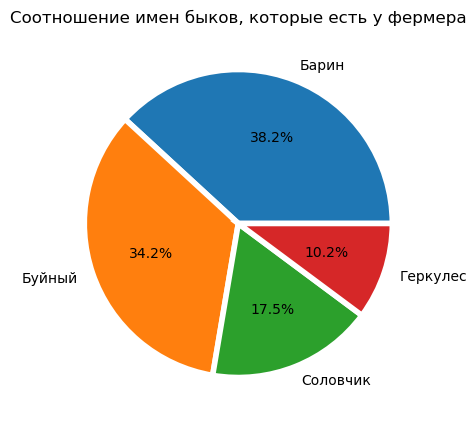

In [49]:
# Cтроим круговую диаграмму
plt.figure(figsize=(10, 5))
plt.pie(name_dad.values, labels=name_dad.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение имен быков, которые есть у фермера');

В результате выяснили, что в стаде фермера преобладают имена быков `Барин` - 38.2% и `Буйный` - 34.1%, а процентноее соотношение всех имен следующее:
- `Барин` - 38.2%
- `Буйный` - 34.2%
- `Соловчик` - 17.5%
- `Геркулес` - 10.2%

## Анализ `cow_buy`

Сделаем анализ для таблицы `cow_buy`

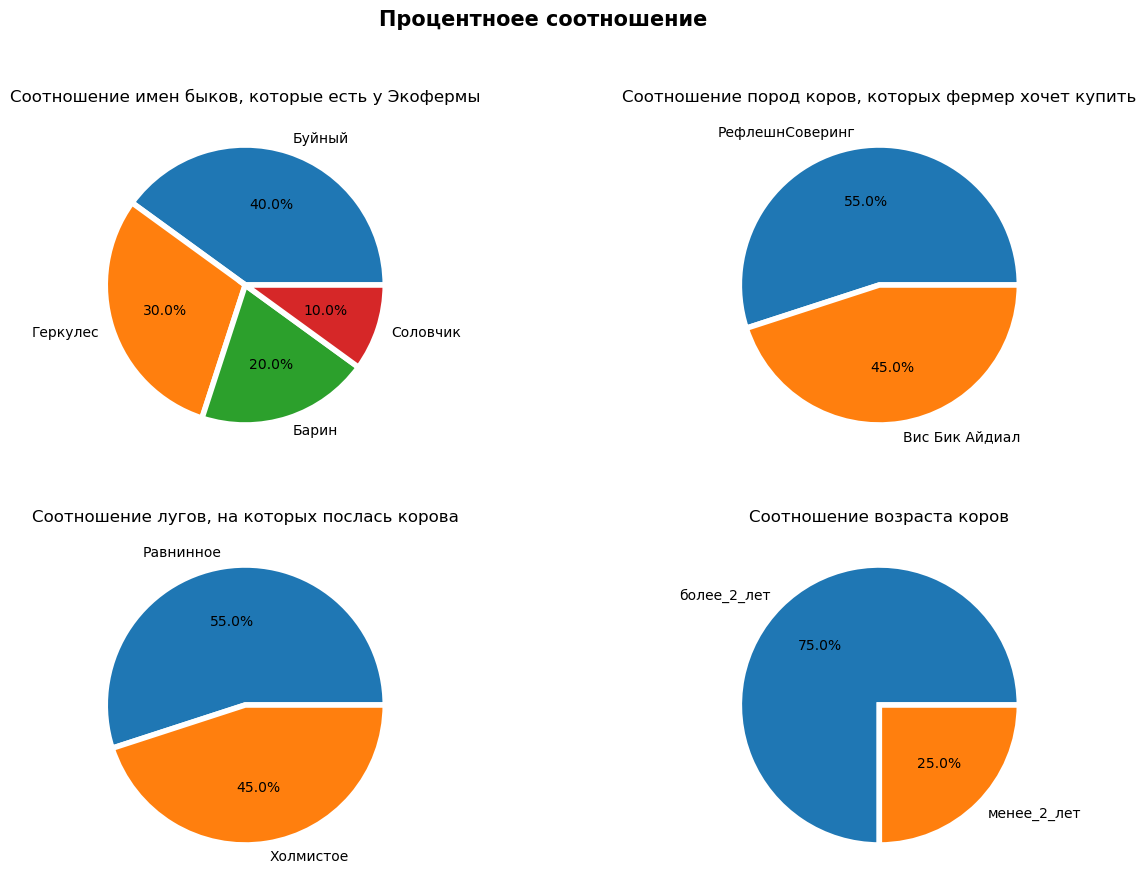

In [50]:
plt.figure(figsize=(15, 10))

plt.suptitle('Процентноее соотношение', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
plt.pie(name_dad_cow_buy.values, labels=name_dad_cow_buy.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение имен быков, которые есть у Экофермы')

plt.subplot(2, 2, 2)
plt.pie(breed_cow_buy.values, labels=breed_cow_buy.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение пород коров, которых фермер хочет купить')

plt.subplot(2, 2, 3)
plt.pie(pasture_cow_buy.values, labels=pasture_cow_buy.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение лугов, на которых послась корова')

plt.subplot(2, 2, 4)
plt.pie(cow_buy['Возраст'].value_counts().values,
        labels=cow_buy['Возраст'].value_counts().index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение возраста коров');

В результате можно сказать следующие:

- У коров, которых хочет купить фермер их имена папы быков преобладают `Буйный` - 40% и `Геркулес` - 30%
- В стаде Экофермы преобладают коровы породы `РефлешнСоверинг`
- В стаде Экофермы преобладают коровы, которые паслись на равнинных пастбищах
- В стаде экофермы, которых отобрал фермер для своей покупки преобладают коровы старше 2 лет и составляют 75% от всего стада

Изучим количественные переменый датафрейма `cow_buy` при помощи диаграммы размаха.

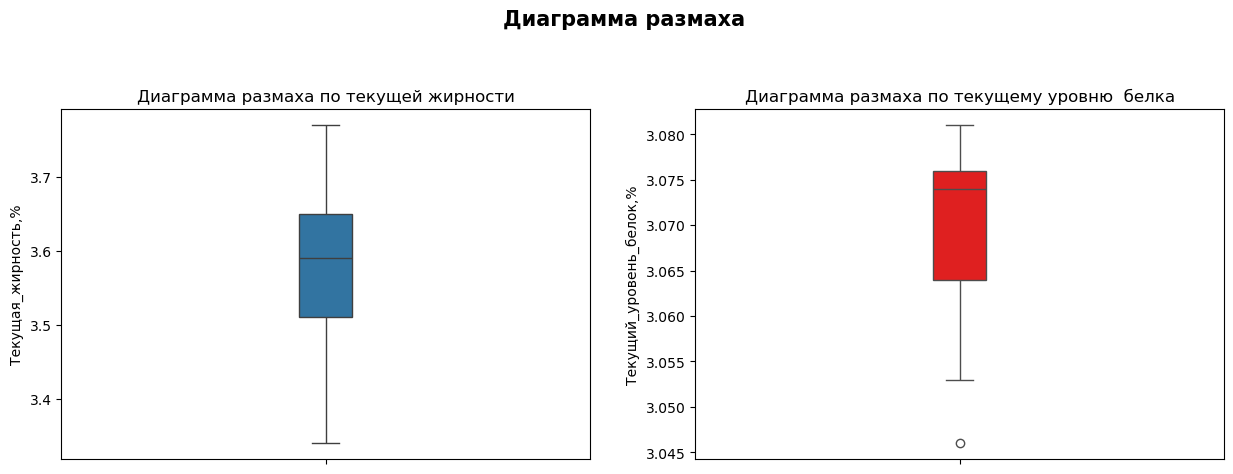

In [51]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(y=cow_buy['Текущая_жирность,%'], width=.1)
plt.title('Диаграмма размаха по текущей жирности')

plt.subplot(2, 2, 2)
sns.boxplot(y=cow_buy['Текущий_уровень_белок,%'], width=.1, color='red')
plt.title('Диаграмма размаха по текущему уровню  белка');

В результате получили:

- Исходя из диаграммы размаха по текущей жирности выбросов необнаружено.
    
- Исходя из диаграммы размаха по текущему уровню белка виден 1 выброс, он не выглядит аномальным и мы не удаляем его. Также по заданию необходимо выбрать коров из 20, а если удалим, их станет меньше.

Теперь построим гистограммы по количественным переменным.

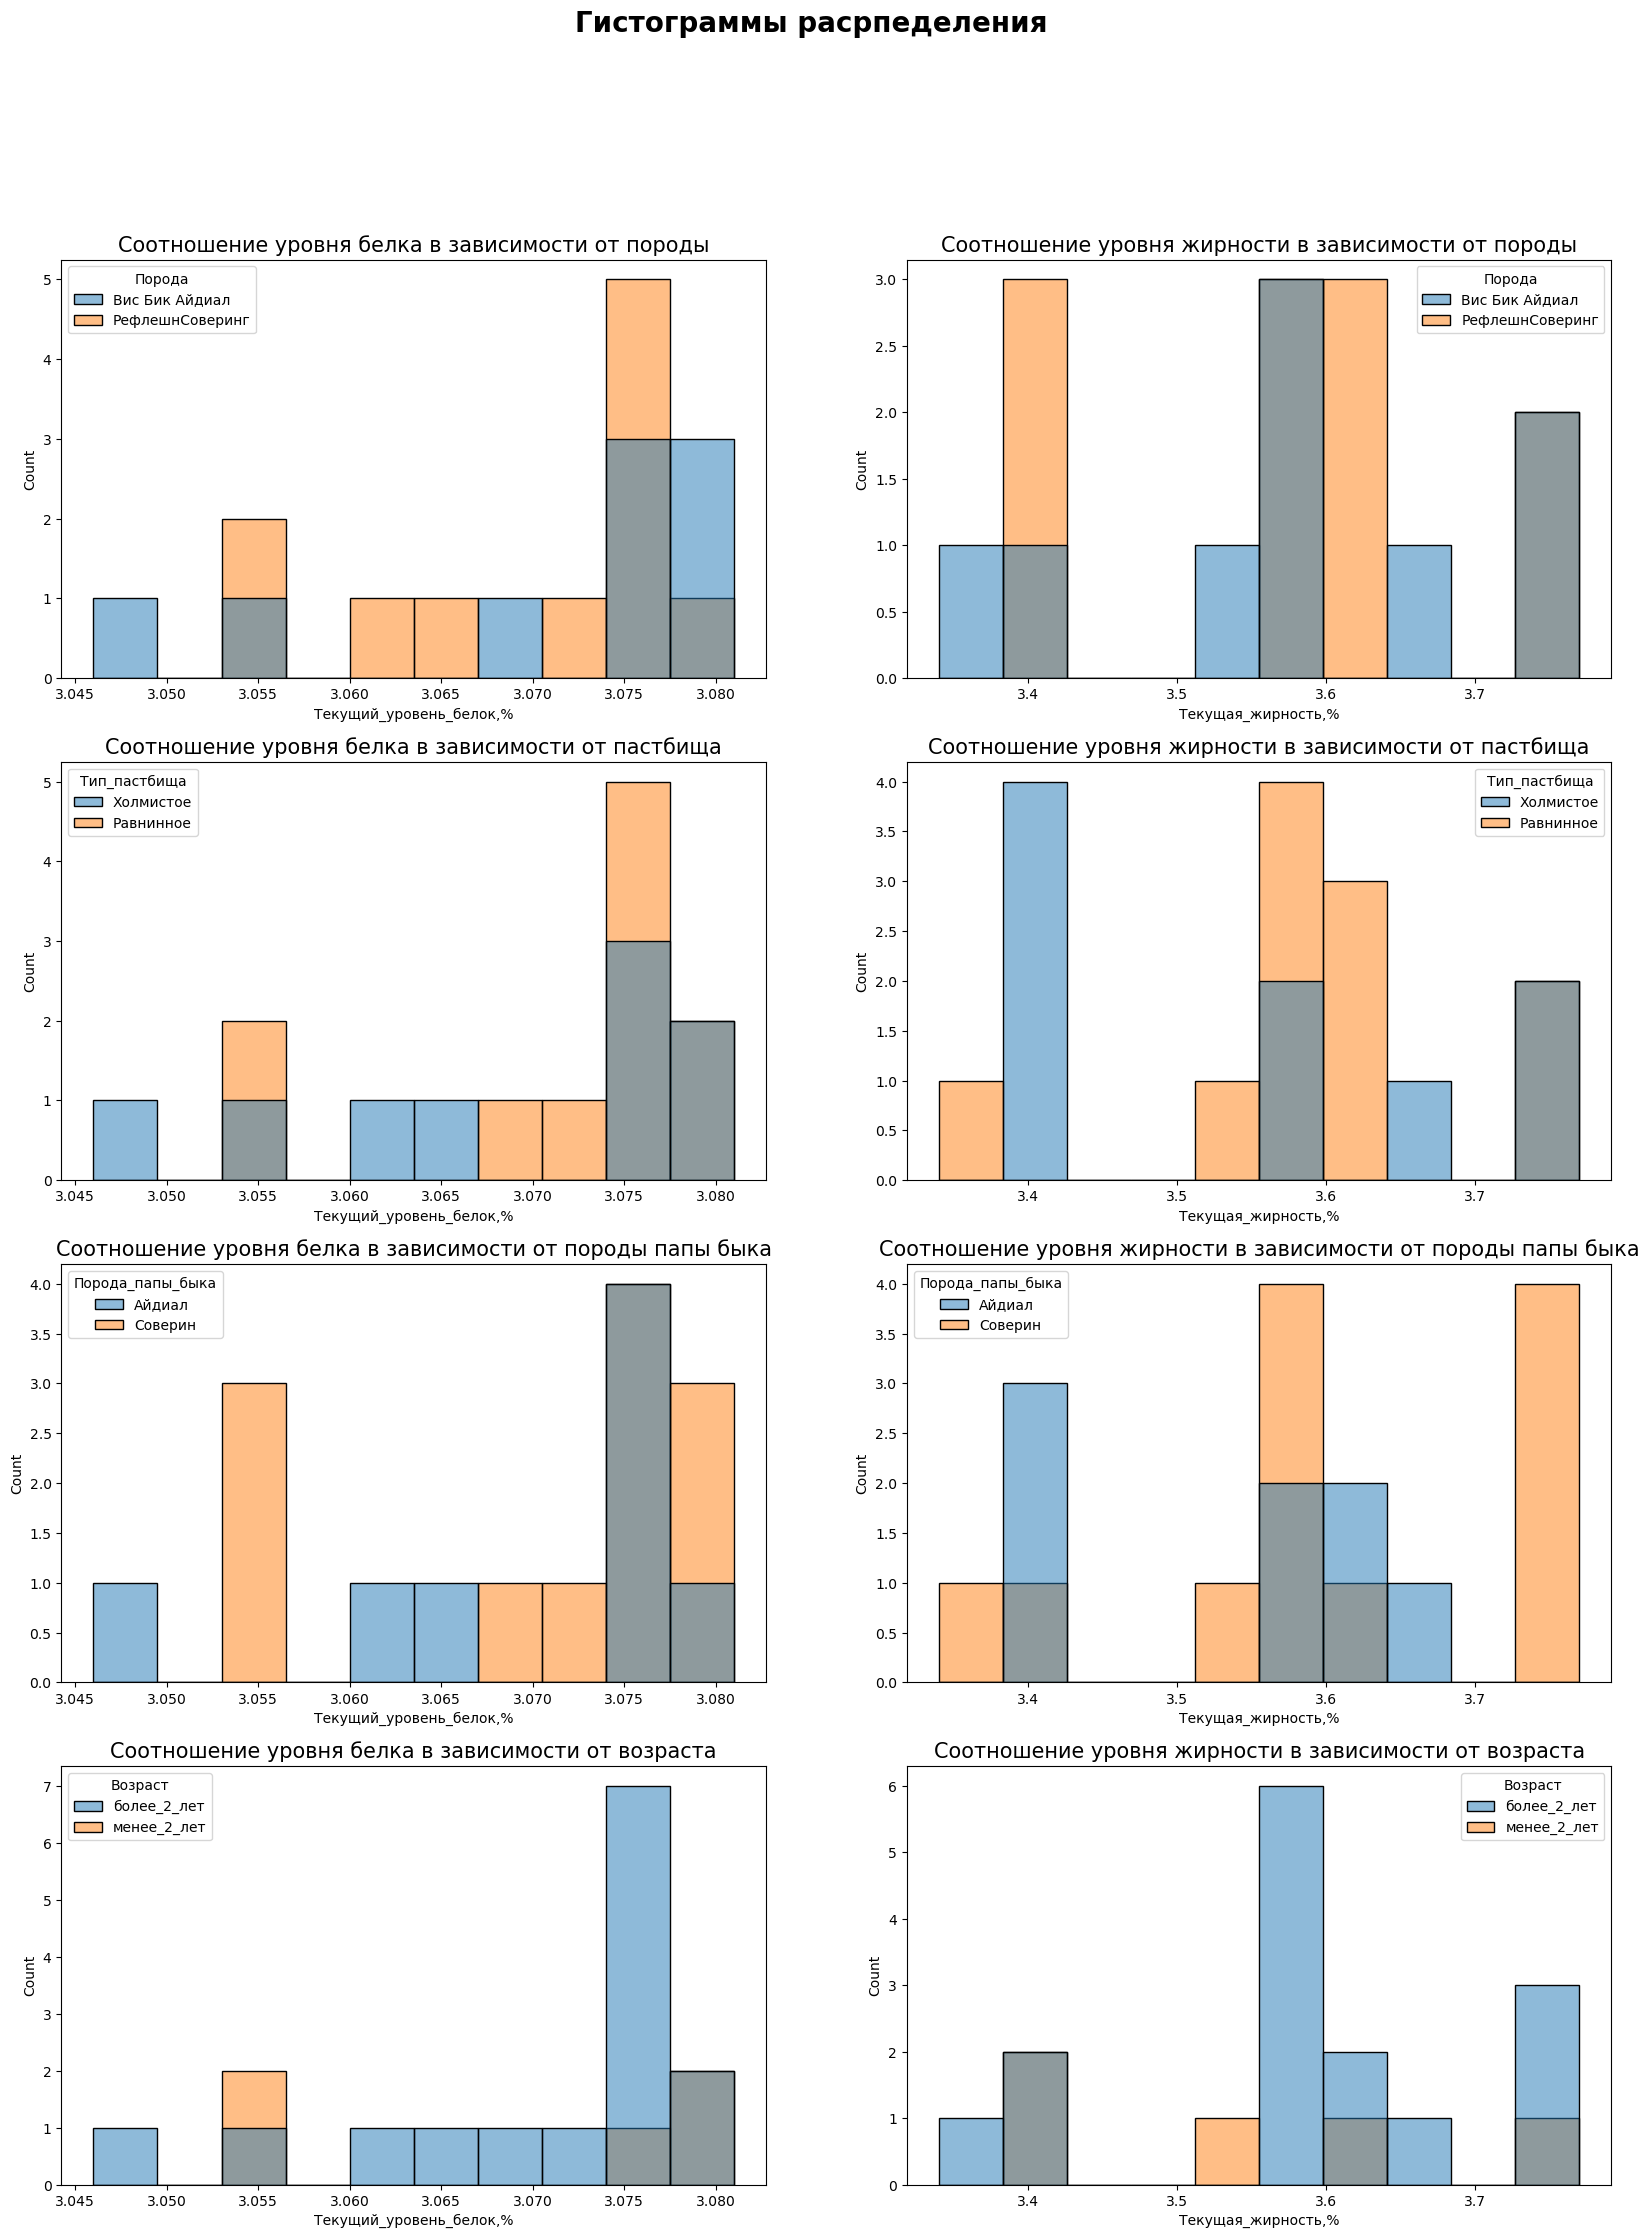

In [52]:
plt.figure(figsize=(20, 25))

plt.suptitle('Гистограммы расрпеделения', fontsize=20, fontweight='bold')

plt.subplot(4, 2, 1)
sns.histplot(data=cow_buy, x='Текущий_уровень_белок,%',
             hue='Порода', bins=10)
plt.title('Соотношение уровня белка в зависимости от породы', fontsize=15)

plt.subplot(4, 2, 2)
sns.histplot(data=cow_buy, x='Текущая_жирность,%',
             hue='Порода', bins=10)
plt.title('Соотношение уровня жирности в зависимости от породы', fontsize=15)

plt.subplot(4, 2, 3)
sns.histplot(data=cow_buy, x='Текущий_уровень_белок,%',
             hue='Тип_пастбища', bins=10)
plt.title('Соотношение уровня белка в зависимости от пастбища', fontsize=15)

plt.subplot(4, 2, 4)
sns.histplot(data=cow_buy, x='Текущая_жирность,%',
             hue='Тип_пастбища', bins=10)
plt.title('Соотношение уровня жирности в зависимости от пастбища', fontsize=15)

plt.subplot(4, 2, 5)
sns.histplot(data=cow_buy, x='Текущий_уровень_белок,%',
             hue='Порода_папы_быка', bins=10)
plt.title('Соотношение уровня белка в зависимости от породы папы быка', fontsize=15)

plt.subplot(4, 2, 6)
sns.histplot(data=cow_buy, x='Текущая_жирность,%',
             hue='Порода_папы_быка', bins=10)
plt.title(
    'Соотношение уровня жирности в зависимости от породы папы быка', fontsize=15)

plt.subplot(4, 2, 7)
sns.histplot(data=cow_buy, x='Текущий_уровень_белок,%',
             hue='Возраст', bins=10)
plt.title('Соотношение уровня белка в зависимости от возраста', fontsize=15)

plt.subplot(4, 2, 8)
sns.histplot(data=cow_buy, x='Текущая_жирность,%',
             hue='Возраст', bins=10)
plt.title('Соотношение уровня жирности в зависимости от возраста', fontsize=15);

Данные имеют ненормальное распределение. Также можно сказать, что самый частый уровень белка 3.075%, а самая частая жирность 3.6%. Судя по гистограмме "соотношения уровня жирности", для обучения модели, жирность можно представить в виде категориальнной переменной, так как отчетливо видно 3 кластера.

## Анализ `ferma_main`

Построи круговую диаграмму, чтобы посмотреть процентное соотношение пород у фермера.

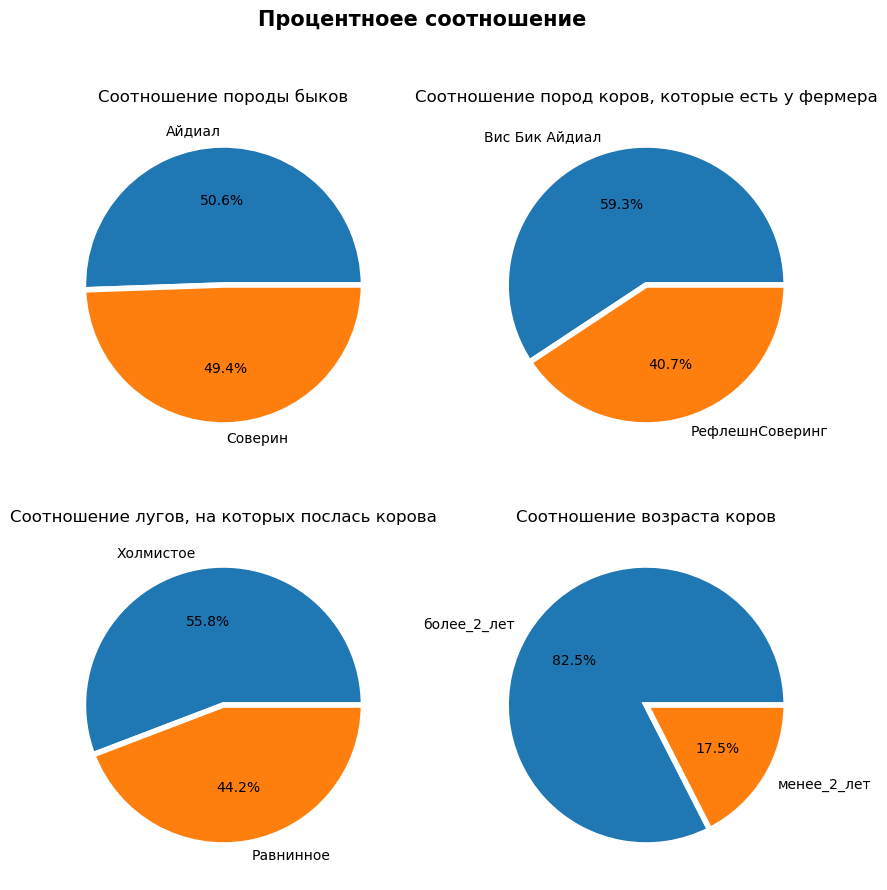

In [53]:
plt.figure(figsize=(10, 10))

plt.suptitle('Процентноее соотношение', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
plt.pie(breed_dad.values, labels=breed_dad.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение породы быков')

plt.subplot(2, 2, 2)
plt.pie(breed_cow.values, labels=breed_cow.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение пород коров, которые есть у фермера')

plt.subplot(2, 2, 3)
plt.pie(pasture_type.values, labels=pasture_type.index, wedgeprops={
        'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение лугов, на которых послась корова')

plt.subplot(2, 2, 4)
plt.pie(ferma_main['Возраст'].value_counts().values,
        labels=ferma_main['Возраст'].value_counts().index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Соотношение возраста коров');

В результате получаем следующие:

- В стаде фермера преобладают коровы породы `Вис Бик Айдиал`
- В стаде фермера, преобладают коровы, которые паслись на холмистых лугах
- В стаде фермера практически одинаковое соотношение пород быков. Айдиал сосотавляют 50.6% от общего числа, а Соверин 49.4% соотвествено.
- В стаде фермера преобладают коровы старше 2 лет и составляют 82.5% от всего стада

Изучим количественные переменый датафрейма `ferma_main` при помощи диаграммы размаха.

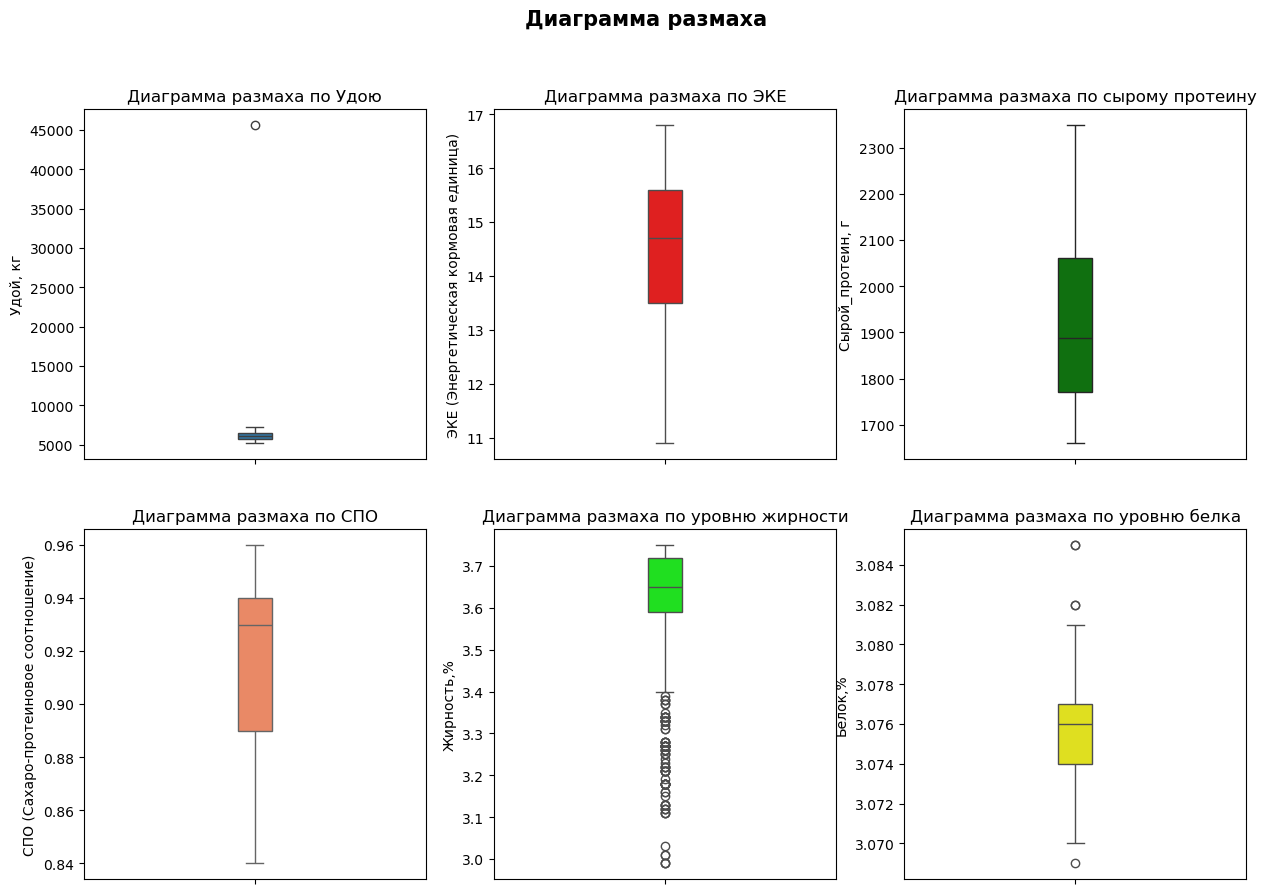

In [54]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха', fontsize=15, fontweight='bold')

plt.subplot(2, 3, 1)
sns.boxplot(y=ferma_main['Удой, кг'], width=.1)
plt.title('Диаграмма размаха по Удою')

plt.subplot(2, 3, 2)
sns.boxplot(y=ferma_main['ЭКЕ (Энергетическая кормовая единица)'], width=.1, color='red')
plt.title('Диаграмма размаха по ЭКЕ')

plt.subplot(2, 3, 3)
sns.boxplot(y=ferma_main['Сырой_протеин, г'], width=.1, color='green')
plt.title('Диаграмма размаха по сырому протеину')

plt.subplot(2, 3, 4)
sns.boxplot(y=ferma_main['СПО (Сахаро-протеиновое соотношение)'], width=.1, color='coral')
plt.title('Диаграмма размаха по СПО')

plt.subplot(2, 3, 5)
sns.boxplot(y=ferma_main['Жирность,%'], width=.1, color='lime')
plt.title('Диаграмма размаха по уровню жирности')

plt.subplot(2, 3, 6)
sns.boxplot(y=ferma_main['Белок,%'], width=.1, color='yellow')
plt.title('Диаграмма размаха по уровню белка');

В результате видим:

- Есть аномальное значение в виде максимального Удоя больше `45000`. Необходимо изучить эти данные более подробно и посмотреть есть ли еще большие значения. Аномальными значения будем считать больше `15000`.
- Есть аномальные значения по жирности, но как можно увидеть, что максимальный выборос находится около 3%, такая жирность молока возможна и поэтому не будем считать эти данные выбросами и оставим их.
- Есть 3 аномальных значения по уровню белка, но их мы не будем считать выбросами, так как такой уровень белка вполне возможен
- В остальных случаях аномальных значений нет

Изучим большие значения по удою.

In [55]:
ferma_main[ferma_main['Удой, кг'] > 15000]  # Cмотри на зачения больше 15000

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой_протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип_пастбища,Порода_папы_быка,"Жирность,%","Белок,%",Вкус_молока,Возраст
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


Удалим данное аномальное значение из датаферйма `breed_il`, а также из основного дасета `ferma_main`, значение не похоже на реальный удой коров. Также необходимо будет удалить из датафрейма `ferma_dad` строчку с таким же индексом, то есть в нашем случае id = 17.

In [56]:
pd.options.mode.chained_assignment = None

Теперь удалим из основного датафрейма `ferma_main`

In [57]:
ferma_main = ferma_main[ferma_main['Удой, кг']
                        < 10000]  # Удаляем аномальные значение

Удалим строку, которая соотвествует `id` аномального значения.

In [58]:
# Удаляем строку, которая соответвует аномальной строке из другого датафрема
ferma_dad = ferma_dad[ferma_dad['id'] != 17]

Теперь построим гистограммы по количественным переменным.

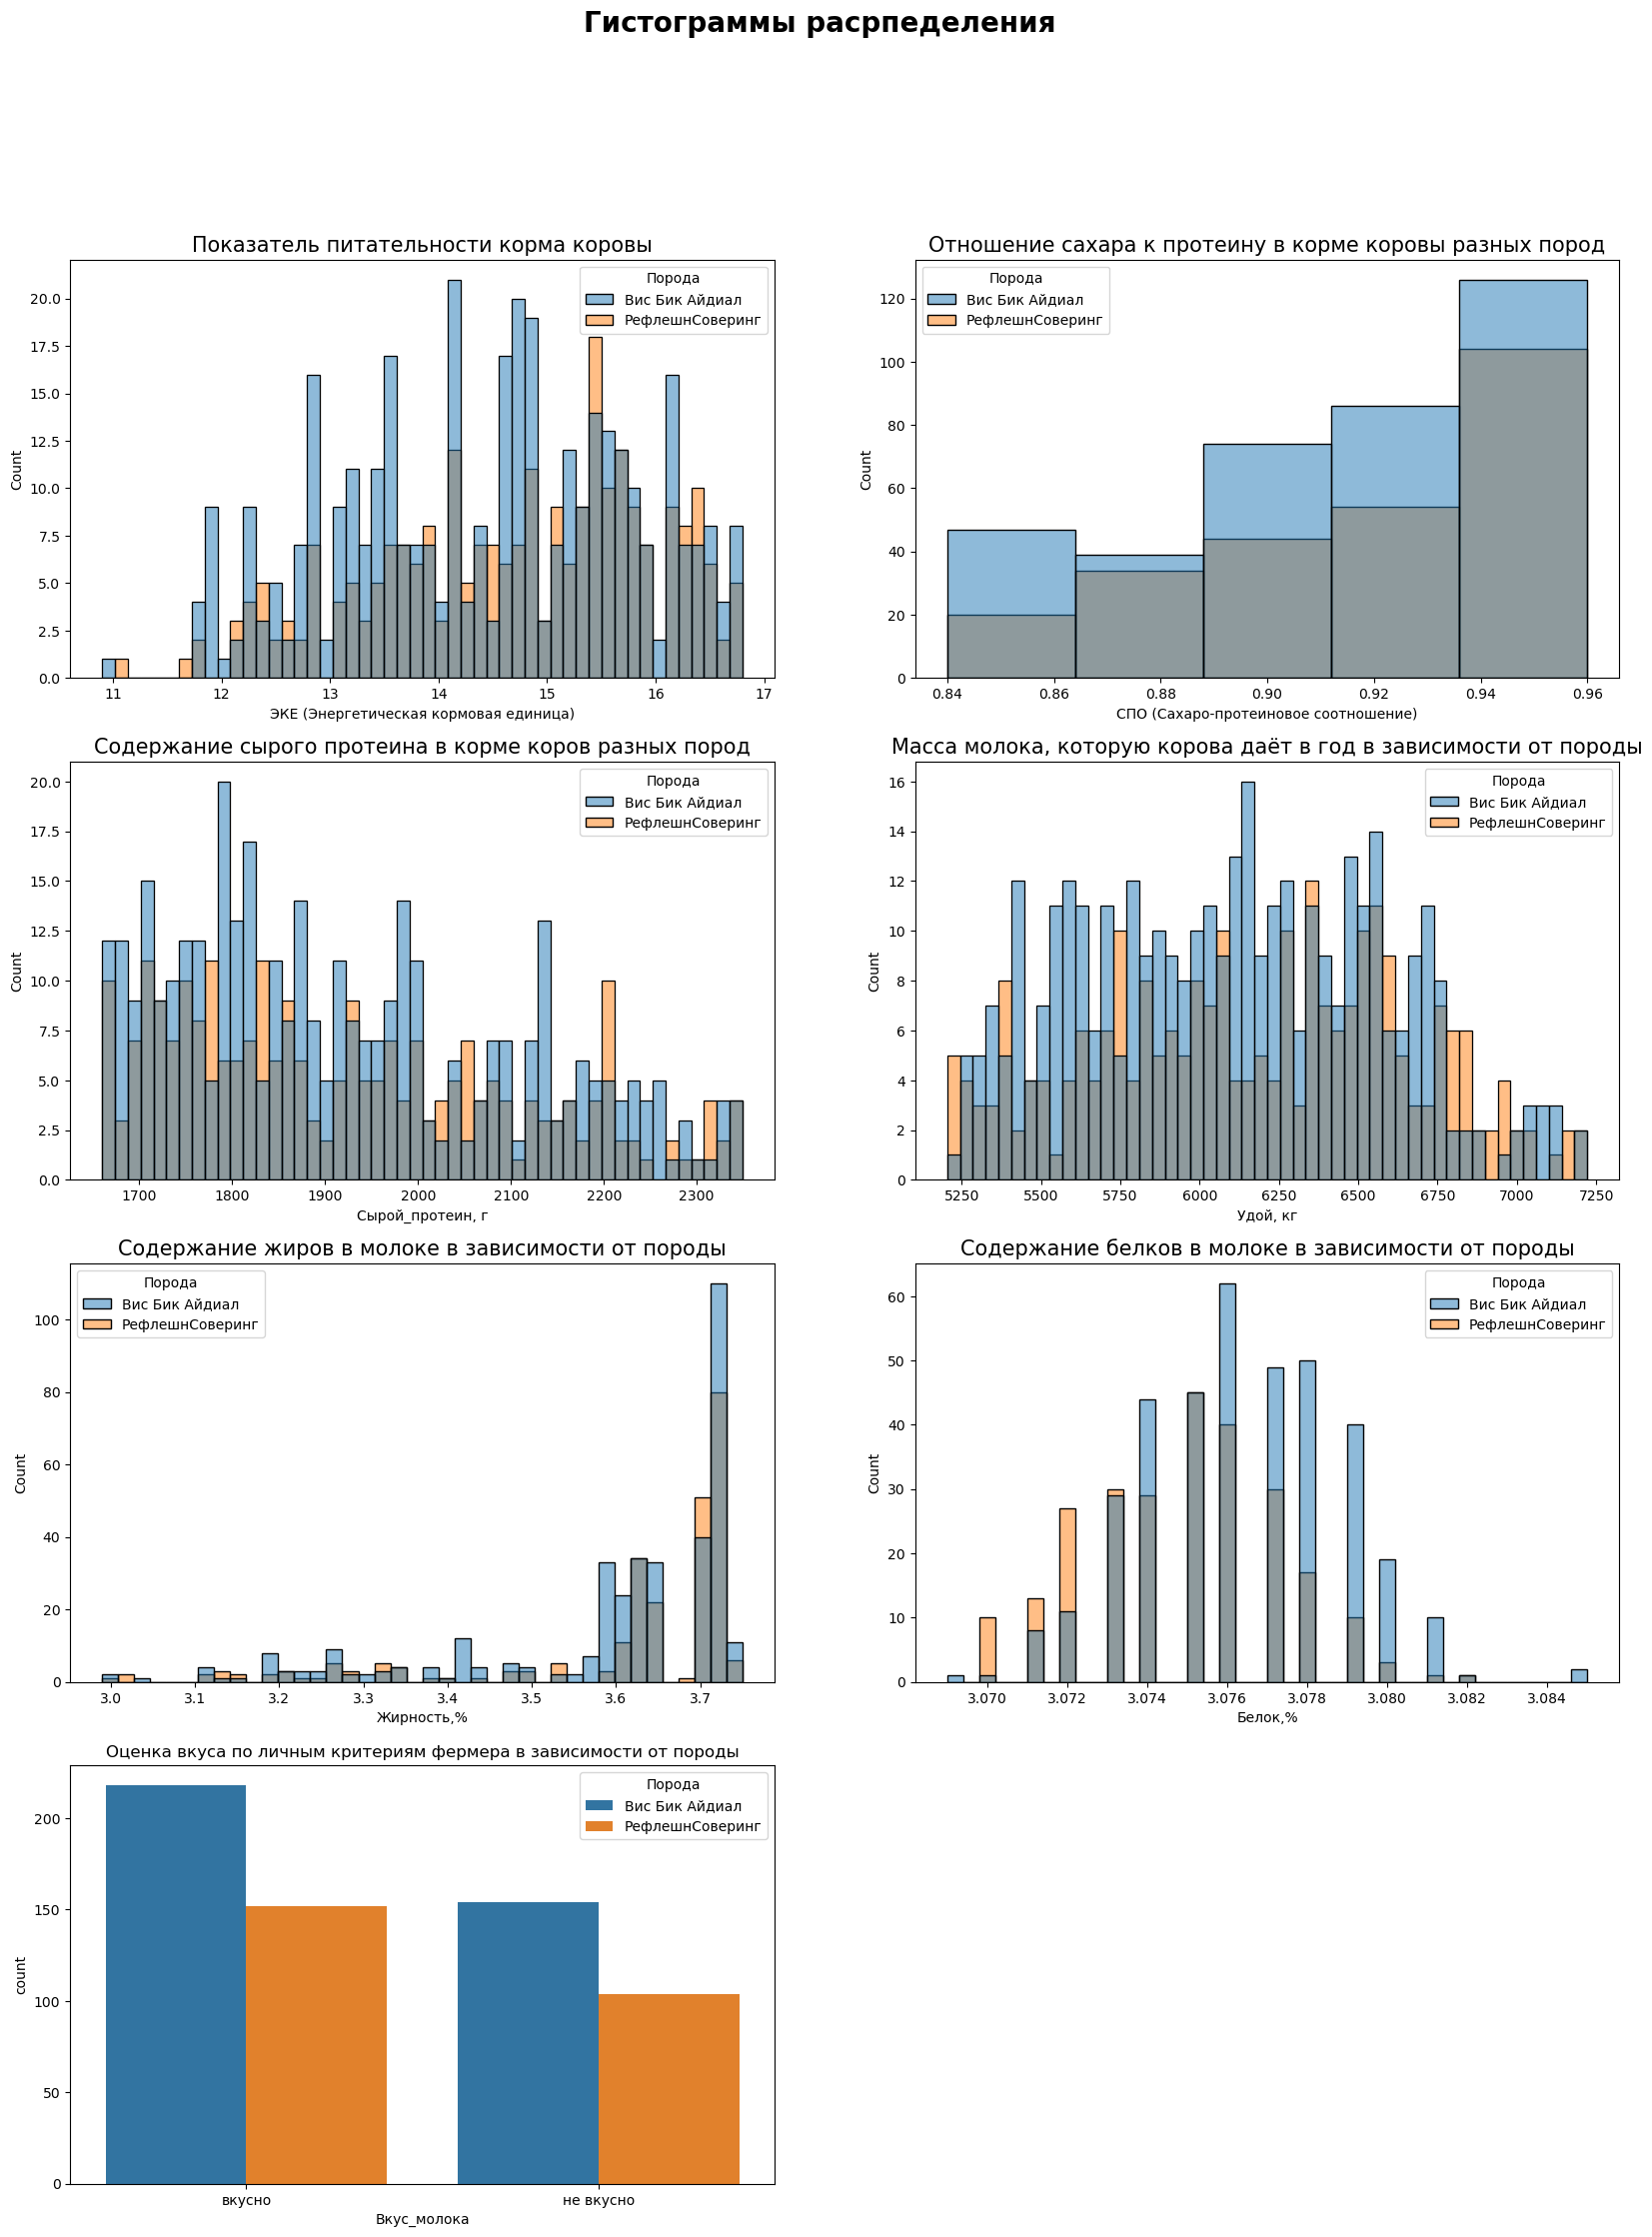

In [59]:
plt.figure(figsize=(20, 25))

plt.suptitle('Гистограммы расрпеделения', fontsize=20, fontweight='bold')

plt.subplot(4, 2, 1)
sns.histplot(data=ferma_main, x='ЭКЕ (Энергетическая кормовая единица)',
             hue='Порода', bins=50)
plt.title('Показатель питательности корма коровы', fontsize=15)

plt.subplot(4, 2, 2)
sns.histplot(data=ferma_main, x='СПО (Сахаро-протеиновое соотношение)',
             hue='Порода', bins=5)
plt.title('Отношение сахара к протеину в корме коровы разных пород', fontsize=15)

plt.subplot(4, 2, 3)
sns.histplot(data=ferma_main, x='Сырой_протеин, г',
             hue='Порода', bins=50)
plt.title('Содержание сырого протеина в корме коров разных пород', fontsize=15)

plt.subplot(4, 2, 4)
sns.histplot(data=ferma_main, x='Удой, кг',
             hue='Порода', bins=50)
plt.title(
    'Масса молока, которую корова даёт в год в зависимости от породы', fontsize=15)

plt.subplot(4, 2, 5)
sns.histplot(data=ferma_main, x='Жирность,%',
             hue='Порода', bins=40)
plt.title('Содержание жиров в молоке в зависимости от породы', fontsize=15)

plt.subplot(4, 2, 6)
sns.histplot(data=ferma_main, x='Белок,%',
             hue='Порода', bins=40)
plt.title(
    'Содержание белков в молоке в зависимости от породы', fontsize=15)

plt.subplot(4, 2, 7)
sns.countplot(data=ferma_main, x='Вкус_молока', hue='Порода')
plt.title('Оценка вкуса по личным критериям фермера в зависимости от породы');

Выводы:

- Признаки имеют ненормальное распределние
- По ЭКЕ практически везде `Вис Бик Айдиал` превосходит  `РефлешнСоверинг`, есть множество пиков, так что распределние мультимодально.
- По СПО `Вис Бик Айдиал` превосходит `РефлешнСоверинг` из-за их количества, возможно если бы соотношения были одинаковые, то впринципе значения не сильно отличались друг от друга.
- По содержанию `сырого протеина`, стоит только отметить пик в райное 2200, а также несколько пиков породы `Вис Бик Айдиал` особенно, который при 1800.
- По удою практически везде `Вис Бик Айдиал` превосходит  `РефлешнСоверинг`, что в принципе ожидаемо, так как этой породы больше в стаде, но необходимо отметить пик в районе 6600, где вторая порода выше. Также есть несколько пиков у первой породы, скорее всего просто из-за того, что их больше.
- Можно отметить, что в основном содержание жиров находится в пределах 3.5% и 3.8%.
- В этом случаем график содержания  белка похож на нормальное распределение, есть некоторый выброс после 3.084 это и есть то самое большое значение. 
- Вкусное молоко обычно у `Вис Бик Айдиал`, но необходимо учитывать, что их попросту больше.

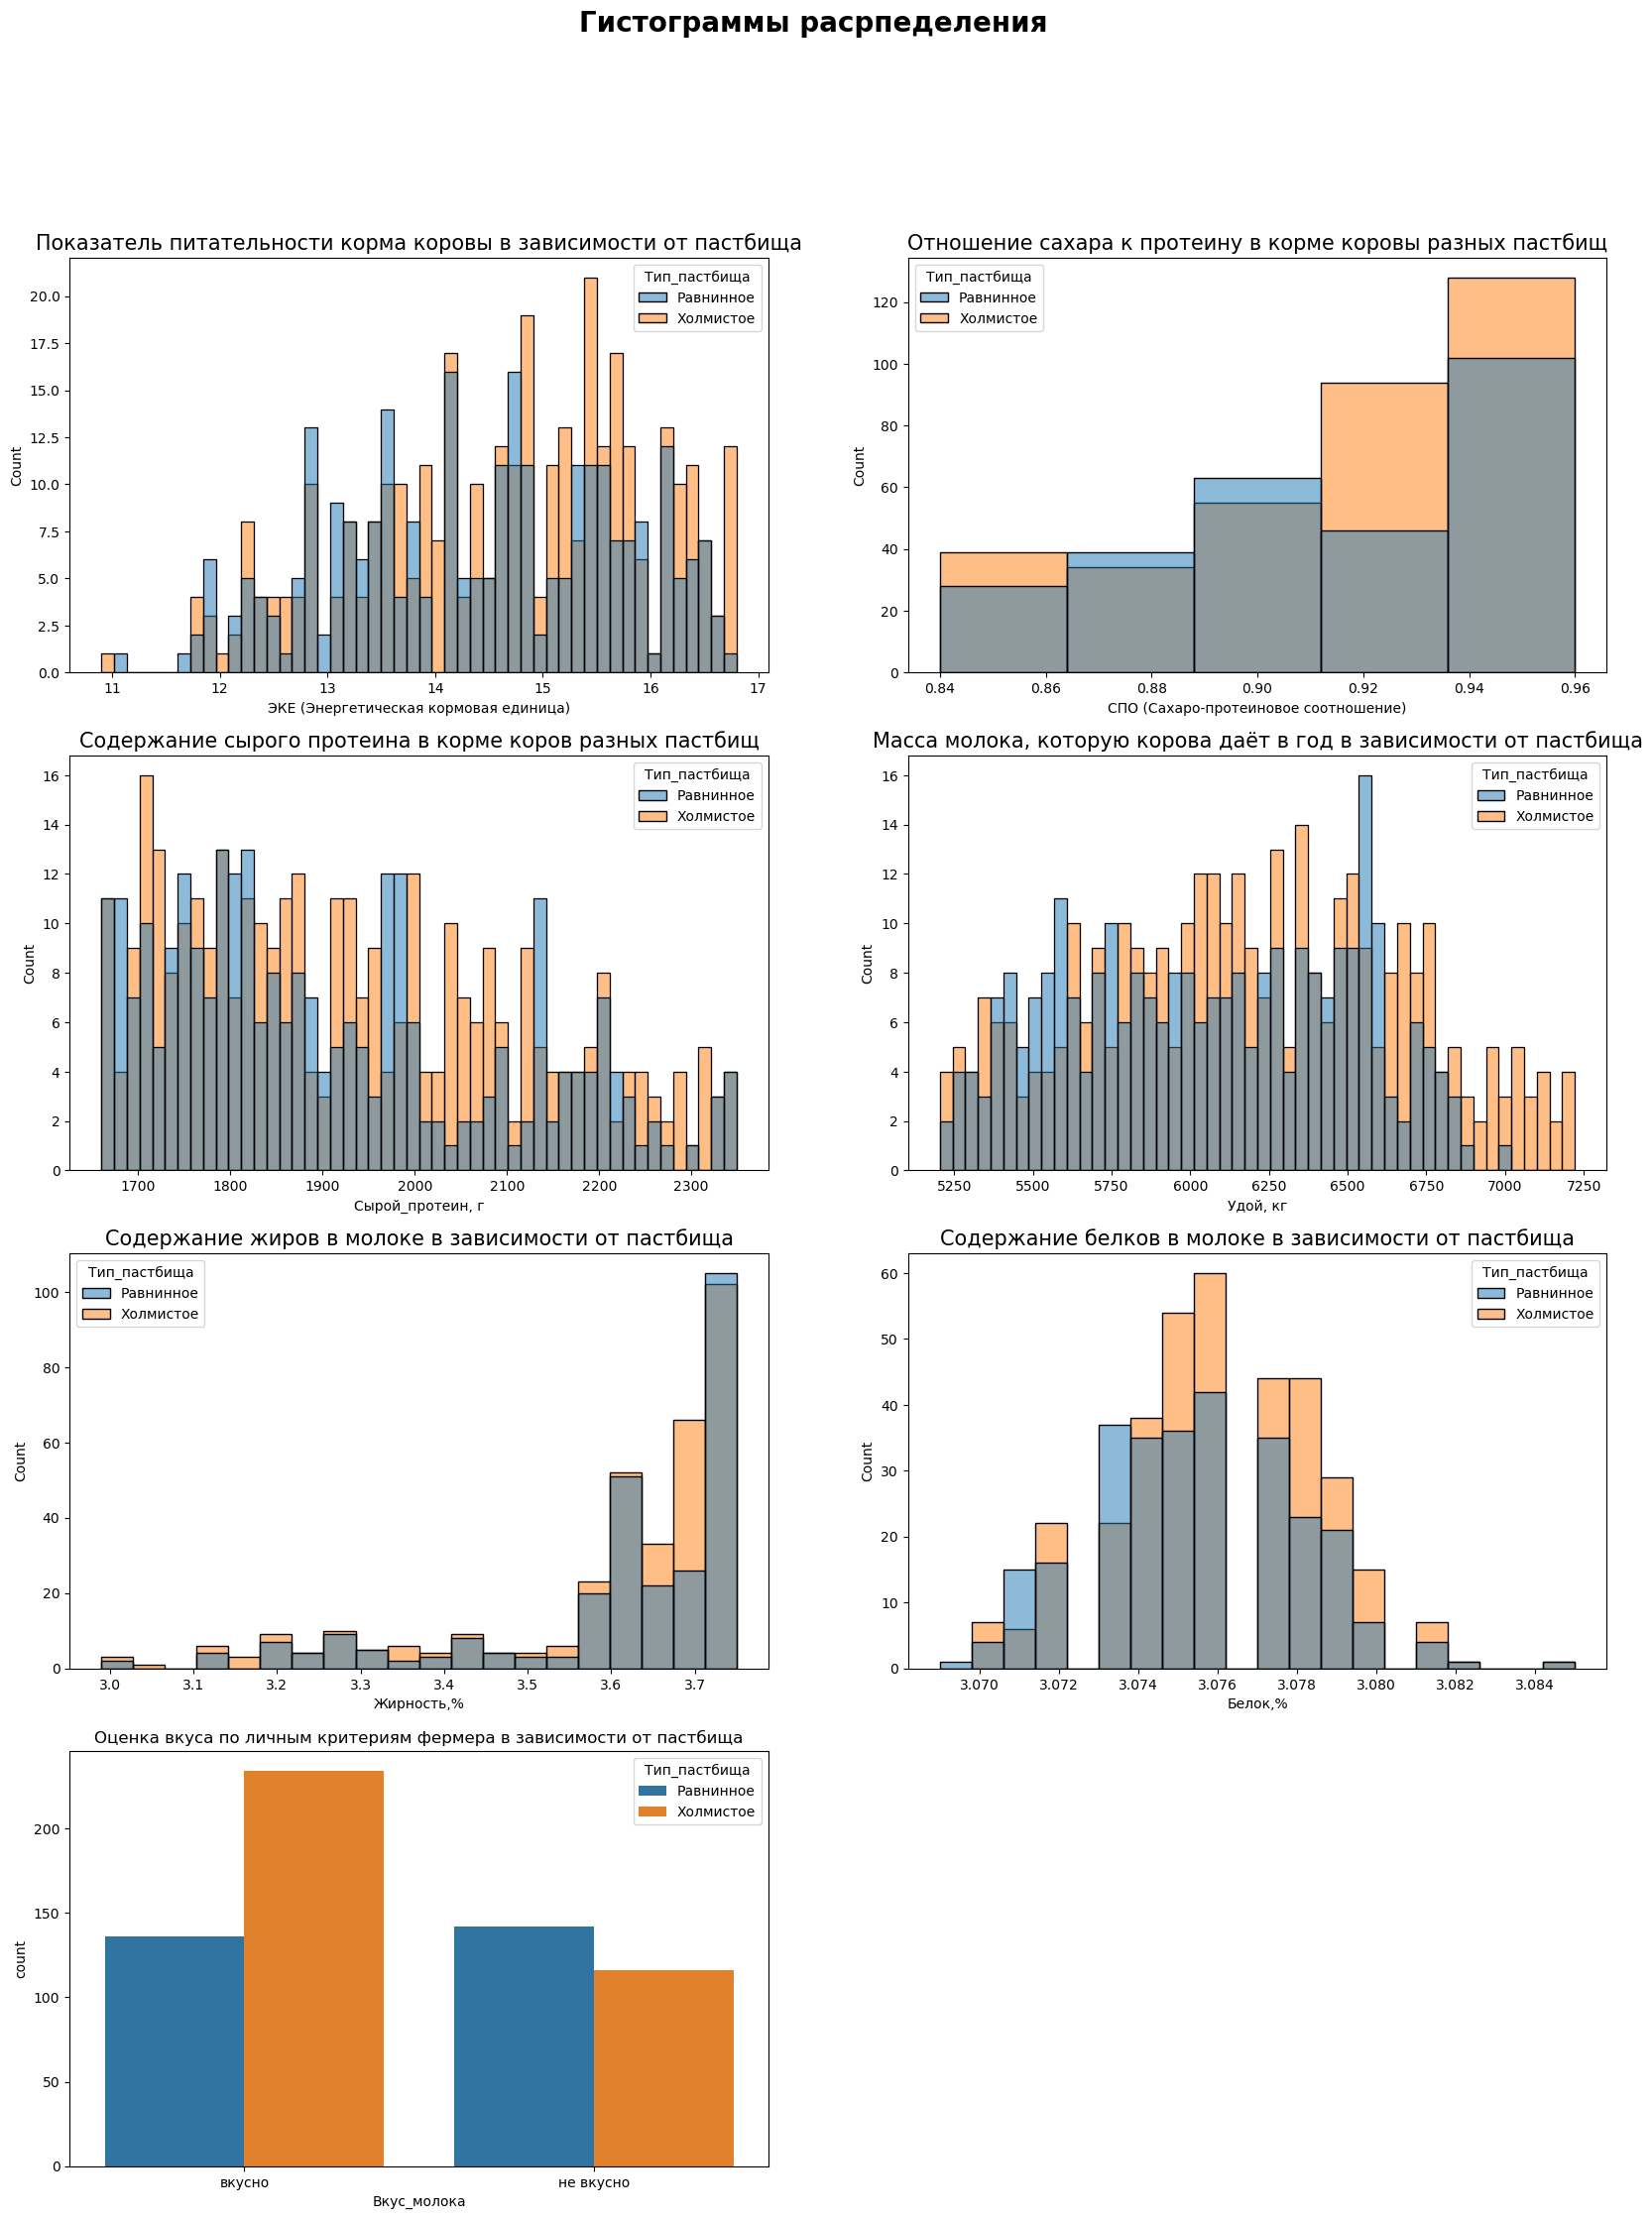

In [60]:
plt.figure(figsize=(20, 25))

plt.suptitle('Гистограммы расрпеделения', fontsize=20, fontweight='bold')

plt.subplot(4, 2, 1)
sns.histplot(data=ferma_main, x='ЭКЕ (Энергетическая кормовая единица)',
             hue='Тип_пастбища', bins=50)
plt.title(
    'Показатель питательности корма коровы в зависимости от пастбища', fontsize=15)

plt.subplot(4, 2, 2)
sns.histplot(data=ferma_main, x='СПО (Сахаро-протеиновое соотношение)',
             hue='Тип_пастбища', bins=5)
plt.title('Отношение сахара к протеину в корме коровы разных пастбищ', fontsize=15)

plt.subplot(4, 2, 3)
sns.histplot(data=ferma_main, x='Сырой_протеин, г',
             hue='Тип_пастбища', bins=50)
plt.title('Содержание сырого протеина в корме коров разных пастбищ', fontsize=15)

plt.subplot(4, 2, 4)
sns.histplot(data=ferma_main, x='Удой, кг',
             hue='Тип_пастбища', bins=50)
plt.title(
    'Масса молока, которую корова даёт в год в зависимости от пастбища', fontsize=15)

plt.subplot(4, 2, 5)
sns.histplot(data=ferma_main, x='Жирность,%',
             hue='Тип_пастбища', bins=20)
plt.title('Содержание жиров в молоке в зависимости от пастбища', fontsize=15)

plt.subplot(4, 2, 6)
sns.histplot(data=ferma_main, x='Белок,%',
             hue='Тип_пастбища', bins=20)
plt.title(
    'Содержание белков в молоке в зависимости от пастбища', fontsize=15)

plt.subplot(4, 2, 7)
sns.countplot(data=ferma_main, x='Вкус_молока', hue='Тип_пастбища')
plt.title('Оценка вкуса по личным критериям фермера в зависимости от пастбища');

Выводы:

- Признаки имеют ненормальное распределение
- По ЭКЕ график смещен вправо, есть можество пиков, что может говорить о его мультимодальном распределении
- СПО не особо зависит от типа пастбища, можно только отметить сильное различие в диапазоне 0.915 до 0.9375. Здесь сильнное различие, возможно связано с тем, что коров пасящихся на холмистых пастбищах больше.
- График имеет несколько пиков, что говорит о его мультимодальности
- По удою тип пастбища `Холмистое` преобладает практически на всем графике, стоит отметить пик в районе 6600, где очень сильно выделяется `Равниное`. 
- По жирности до жирности 3.6% разница между пастибищами минимальна. В районе 3.7 тип пастбища холмистое имеет больше коров, скорее всего также связано с разной величиной датасетов.
- График содержания белков похож на нормальное распределение смещеное вправо. 
- Хоть выборки и разные, но можно сказать, что более вкусное молоко получается, если корова паслась на холмистом пастбище.

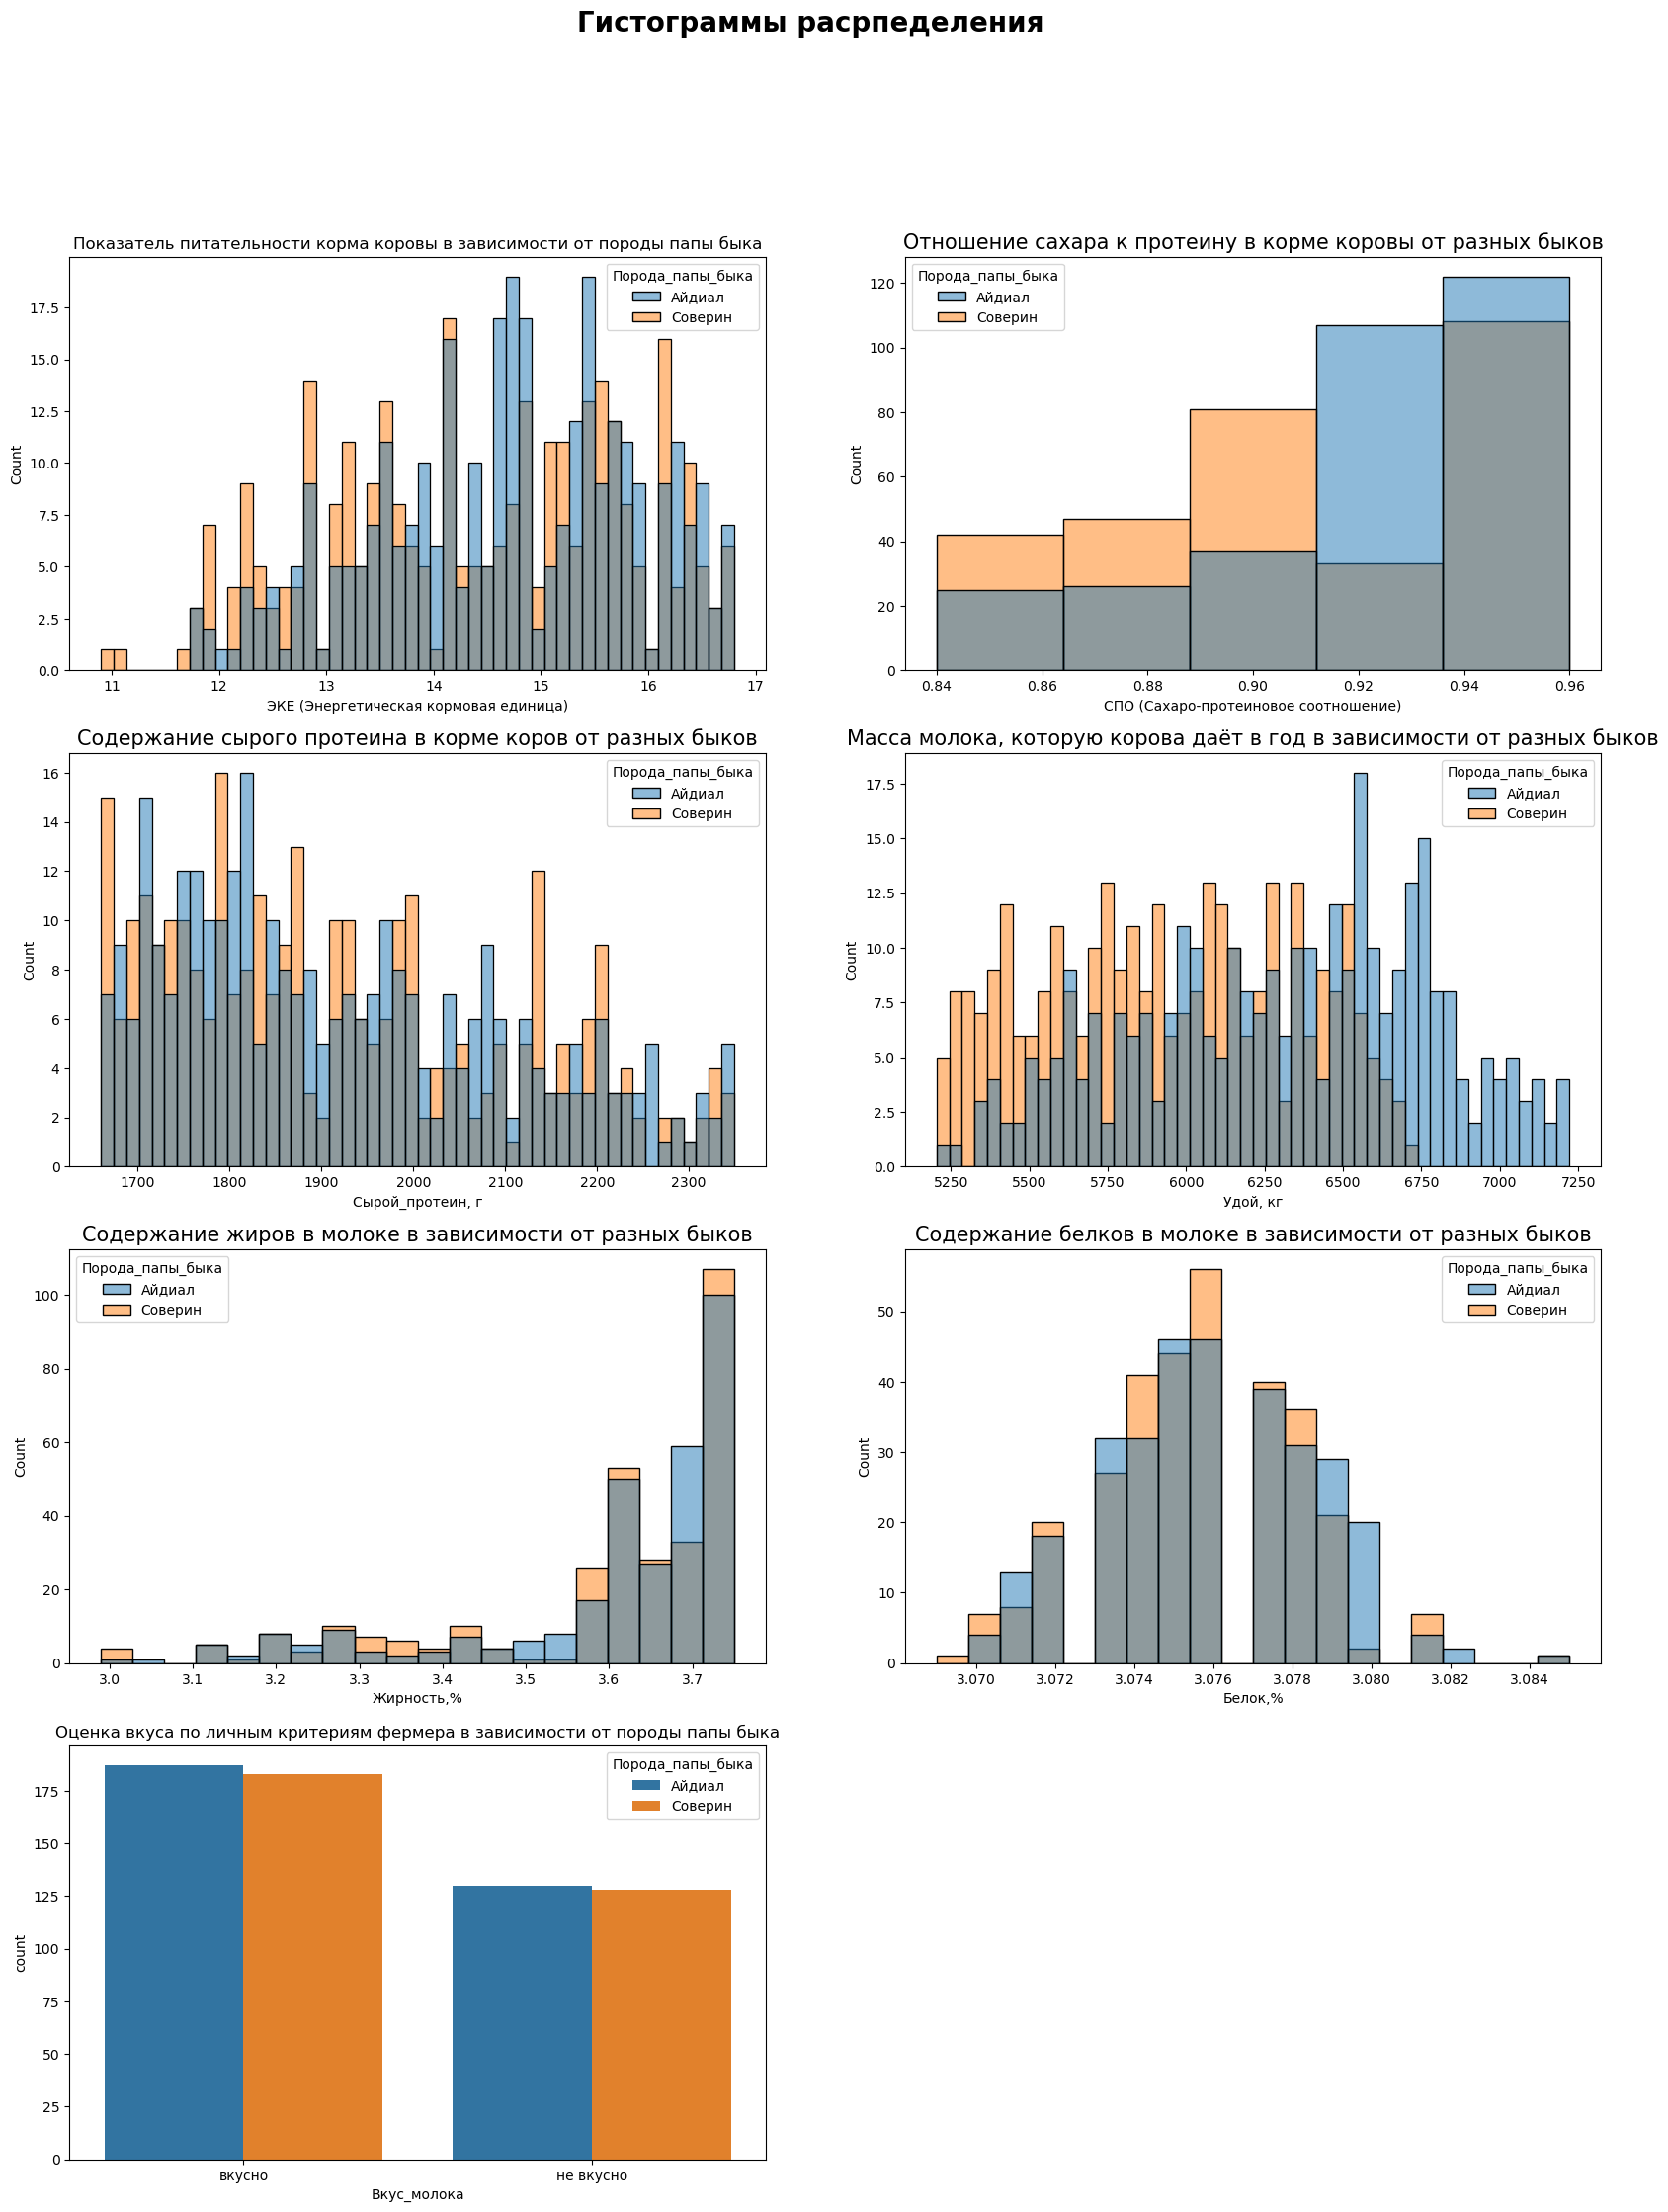

In [61]:
plt.figure(figsize=(20, 25))

plt.suptitle('Гистограммы расрпеделения', fontsize=20, fontweight='bold')

plt.subplot(4, 2, 1)
sns.histplot(data=ferma_main, x='ЭКЕ (Энергетическая кормовая единица)',
             hue='Порода_папы_быка', bins=50)
plt.title('Показатель питательности корма коровы в зависимости от породы папы быка')

plt.subplot(4, 2, 2)
sns.histplot(data=ferma_main, x='СПО (Сахаро-протеиновое соотношение)',
             hue='Порода_папы_быка', bins=5)
plt.title('Отношение сахара к протеину в корме коровы от разных быков', fontsize=15)

plt.subplot(4, 2, 3)
sns.histplot(data=ferma_main, x='Сырой_протеин, г',
             hue='Порода_папы_быка', bins=50)
plt.title('Содержание сырого протеина в корме коров от разных быков', fontsize=15)

plt.subplot(4, 2, 4)
sns.histplot(data=ferma_main, x='Удой, кг',
             hue='Порода_папы_быка', bins=50)
plt.title(
    'Масса молока, которую корова даёт в год в зависимости от разных быков', fontsize=15)

plt.subplot(4, 2, 5)
sns.histplot(data=ferma_main, x='Жирность,%',
             hue='Порода_папы_быка', bins=20)
plt.title('Содержание жиров в молоке в зависимости от разных быков', fontsize=15)

plt.subplot(4, 2, 6)
sns.histplot(data=ferma_main, x='Белок,%',
             hue='Порода_папы_быка', bins=20)
plt.title(
    'Содержание белков в молоке в зависимости от разных быков', fontsize=15)

plt.subplot(4, 2, 7)
sns.countplot(data=ferma_main, x='Вкус_молока', hue='Порода_папы_быка')
plt.title('Оценка вкуса по личным критериям фермера в зависимости от породы папы быка');

Выводы:

- По ЭКЕ, коровы от быка породы Айдиал дают чаще ЭКЕ в районе 14.5 до 15. График похож на мультимодальное распределение. Есть выборос в районе 11.
- Стоит отметить, что СПО до 0.92 двух больше у коров, у которых папа бык породы Соверин. Дальше перевес идет в сторону Айдиал.
- По протеину наблюдаются много пиков, что говорит о мультимодальном расперделении.
- Коровы породы `Айдиал` дают больший удой, чем коровы породы `Соверин`.
- В зависимости от породы папы быка, жирность молока практически одинаковая, есть характерный пик в районе жирности 3.7% у породы `Айдиал`
- График содержания белков похож на нормальное распределение смещеное вправо. 
- Вкус молока не зависит от породы быка. 

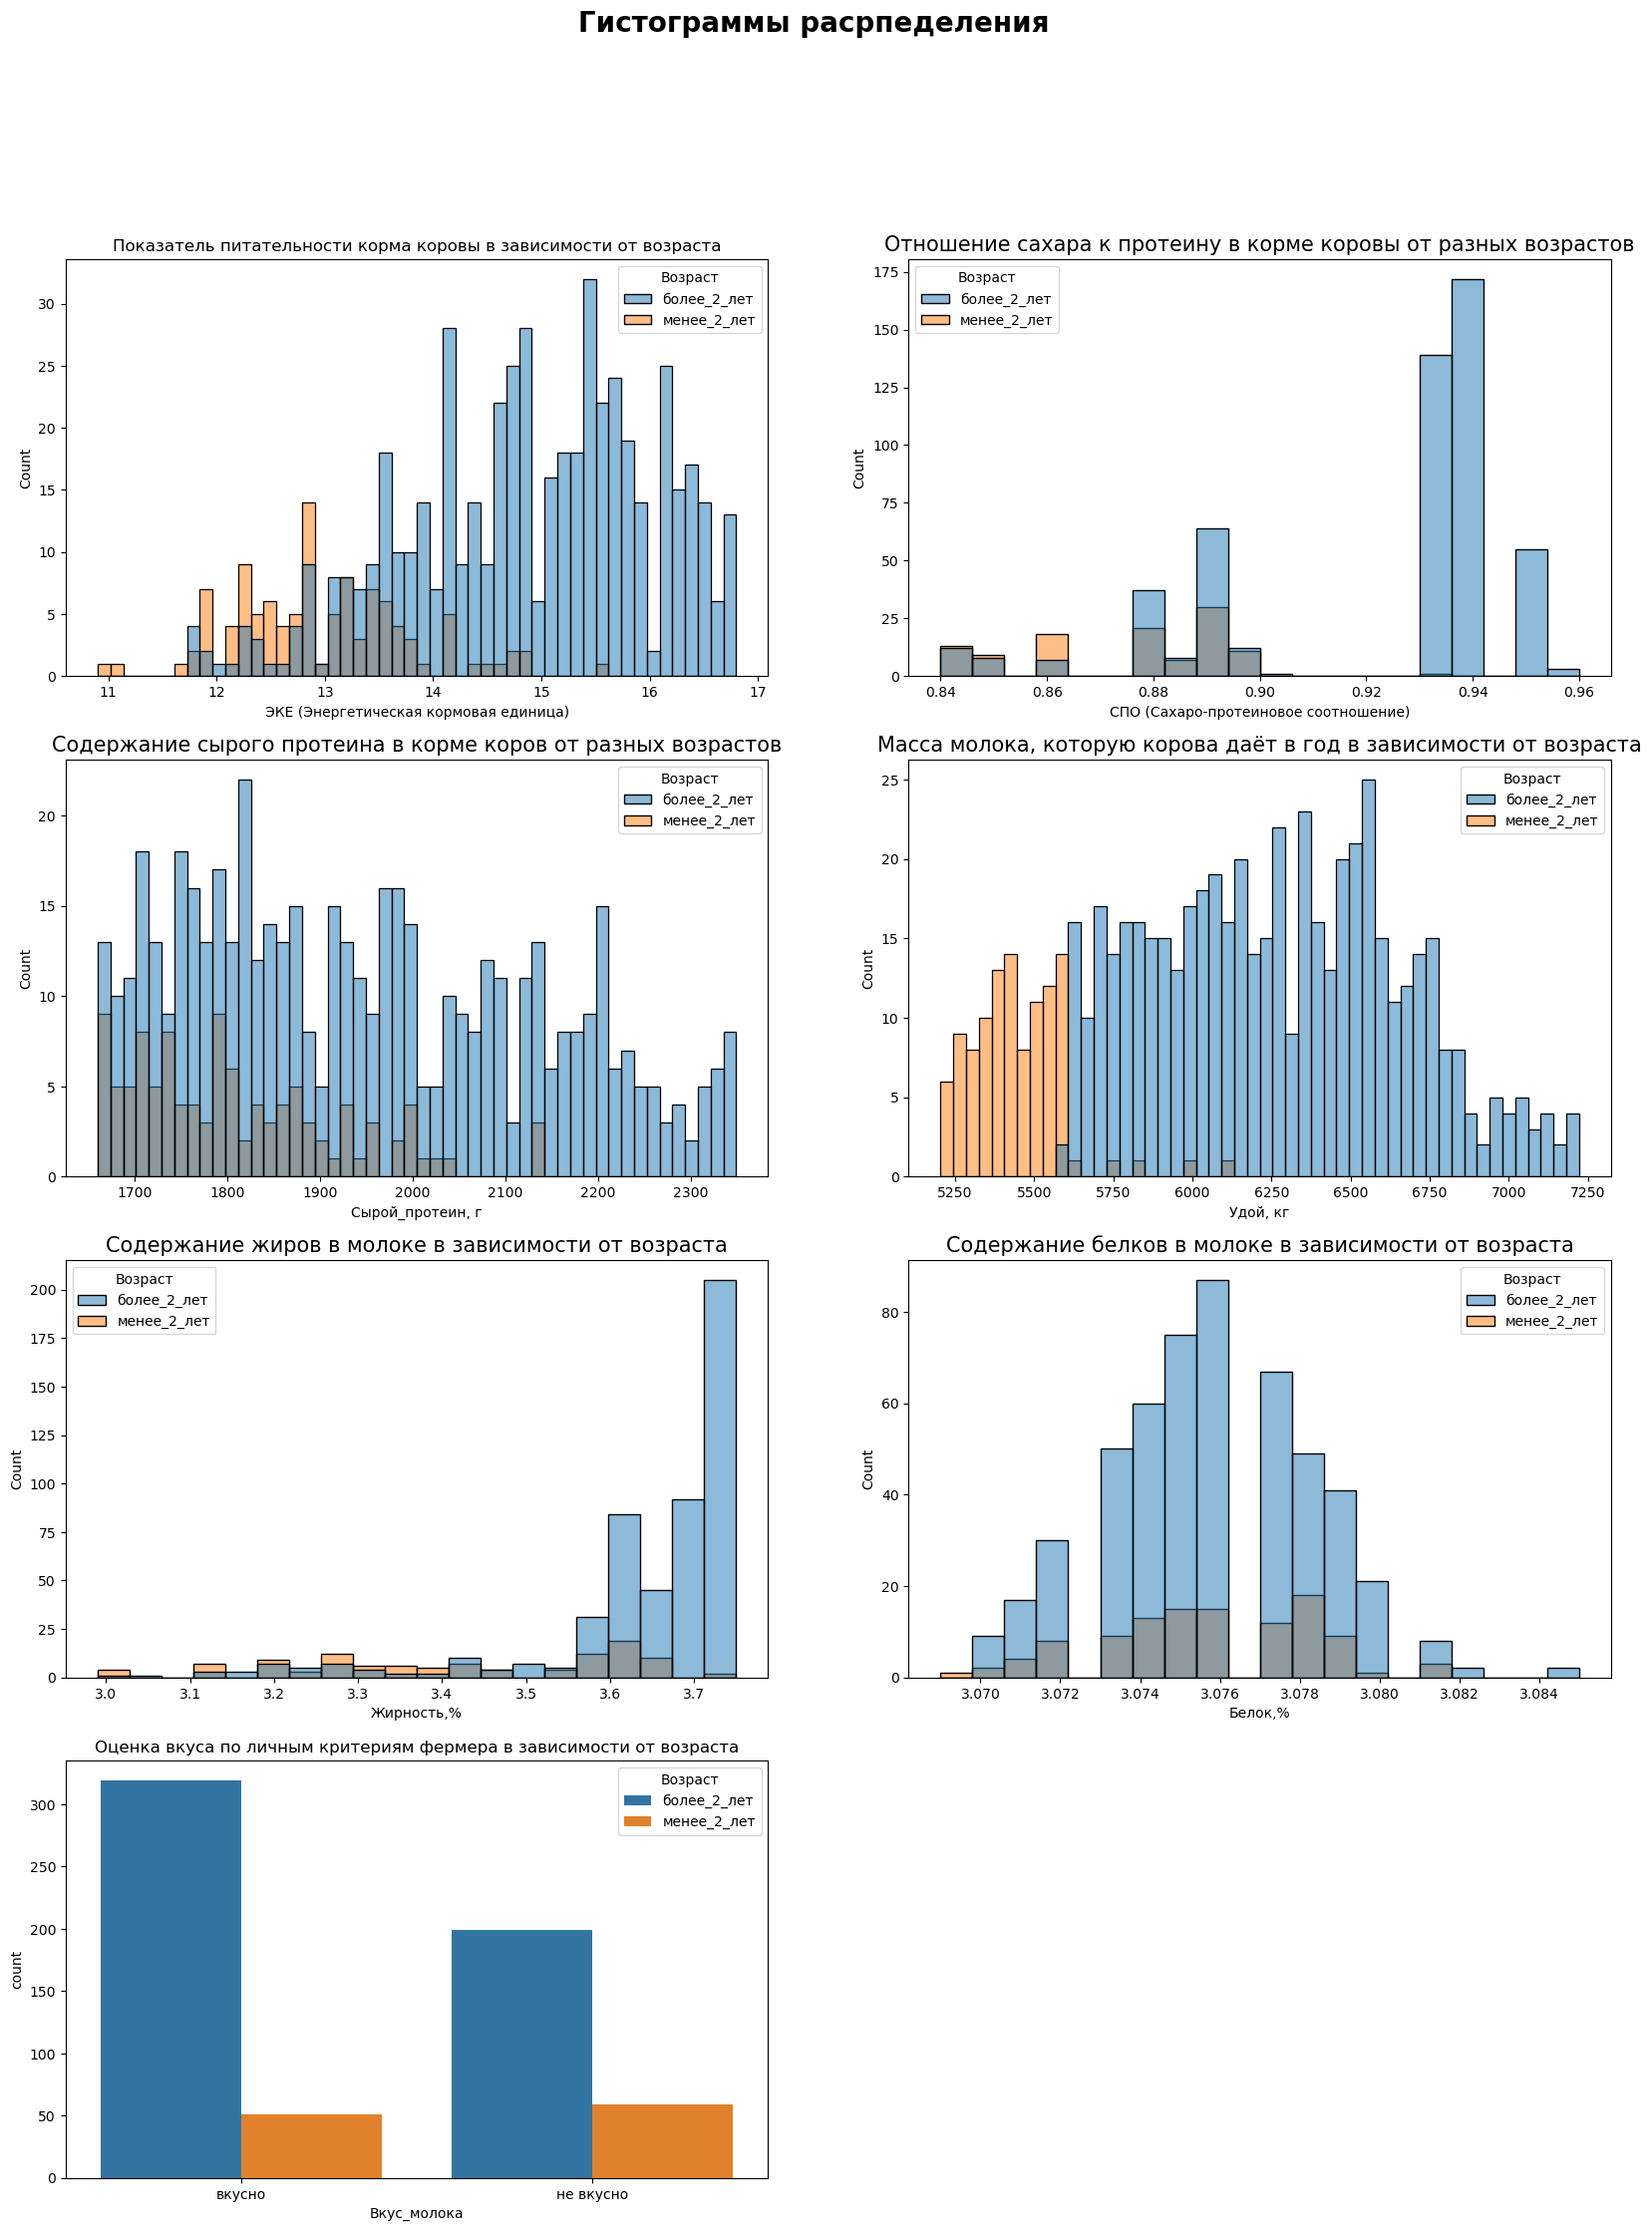

In [62]:
plt.figure(figsize=(20, 25))

plt.suptitle('Гистограммы расрпеделения', fontsize=20, fontweight='bold')

plt.subplot(4, 2, 1)
sns.histplot(data=ferma_main, x='ЭКЕ (Энергетическая кормовая единица)',
             hue='Возраст', bins=50)
plt.title('Показатель питательности корма коровы в зависимости от возраста')

plt.subplot(4, 2, 2)
sns.histplot(data=ferma_main, x='СПО (Сахаро-протеиновое соотношение)',
             hue='Возраст', bins=20)
plt.title(
    'Отношение сахара к протеину в корме коровы от разных возрастов', fontsize=15)

plt.subplot(4, 2, 3)
sns.histplot(data=ferma_main, x='Сырой_протеин, г',
             hue='Возраст', bins=50)
plt.title('Содержание сырого протеина в корме коров от разных возрастов', fontsize=15)

plt.subplot(4, 2, 4)
sns.histplot(data=ferma_main, x='Удой, кг',
             hue='Возраст', bins=50)
plt.title(
    'Масса молока, которую корова даёт в год в зависимости от возраста', fontsize=15)

plt.subplot(4, 2, 5)
sns.histplot(data=ferma_main, x='Жирность,%',
             hue='Возраст', bins=20)
plt.title('Содержание жиров в молоке в зависимости от возраста', fontsize=15)

plt.subplot(4, 2, 6)
sns.histplot(data=ferma_main, x='Белок,%',
             hue='Возраст', bins=20)
plt.title(
    'Содержание белков в молоке в зависимости от возраста', fontsize=15)

plt.subplot(4, 2, 7)
sns.countplot(data=ferma_main, x='Вкус_молока', hue='Возраст')
plt.title('Оценка вкуса по личным критериям фермера в зависимости от возраста');

Выводы:

Как мы убедились раньше при построенние круговой диаграммы, коров младше 2 лет меньше
- По ЭКЕ даже с учетом большой разницы между датафреймами видно, что более взрослые коровы получают корм с более высоким ЭКЕ. 
- Коровы старше 2 лет имееют высокий показатель СПО, чем у молодых коров.
- Корове старше 2 лет имееют более высокое содержание протеина в корме.
- Содержания жиров в молоке до 3.6% одинаково у обоих категорий. После 3.6% содержания жиров у старших коров больше.
- Даже не смотря на большую разницу в датафреймах можно сказать, что вкус молока зависит от возраста коровы.

## Вывод

Можно сделать следующие выводы:
1. В стаде фермера преоблдают имена быков `Барин` - 38.2% и `Буйный` - 34.1%
2. В стаде фермера преобладают коровы старше 2 лет 82.5% от общего числа
3. В стаде фермера коров породы Вис Бик Айдиал больше и составляет 59.3%
4. В стаде фермера 55.8% коров пасутся на холмисты пастбищах
5. В стаде фермера коровы от породы разных быков практически одинаковое количество
6. У коров, которых хочет купить фермер, имена их папы быков преобладают `Буйный` - 40% и `Геркулес` - 30%
7. В стаде Экофермы преобладают коровы породы РефлешнСоверинг - 55%
8. В стаде Экофермы преобладают коровы, которые послись на равнинных пастбищах - 55%
9. В стаде Экофермы, которых отобрал фермер для своей покупки преобладают коровы старше 2 лет и составляют 75% от всего стада
10. В стаде Экофермы информация по текущему уровню белка был найден 1 выброс, он не выглядит аномальным и мы не удаляем его.
11. Самый частый уровень белка 3.075% судя по информации по коровам из Экофермы
12. Жирность можно предстваить в виде категориальнной переменной, так как отчетливо видно 3 кластера.
13. Все графики по всем количественным признакам имеют ненормальное мультимодальное распределние
14. По удой было найдено аномальное значение, которое было удалено
15. Были найдены не значительные выбросы по уровню белка и жирности их не стали удалять
16. Вкус молока скорее всего зависит от типа пастбища и возраста коровы.
17. Удой молока скорее всего зависит от породы коровы.

Для улучшения данных можно удалить некотрые не значительные выбросы. Либо же добавить больше таких выбросов, для того, чтобы модель могла с работать с такими данными.

Также необходимо выяснить у каких признаков между собой имеется взаимосвязь.

# Корреляционный анализ

Исходя из исследовательского анализа стало понятно, что данные в нашем датафреме распределены ненормально, поэтому необходимо использовать коэффициент корреляции $\phi_k$, он может находить взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

Расчитаем корреляцию при помощи библиотеки Фик для всех наших признаков

In [63]:
phik_m = ferma_main.phik_matrix()  # Расчитываем коэффициент корреляции Фи

interval columns not set, guessing: ['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой_протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']


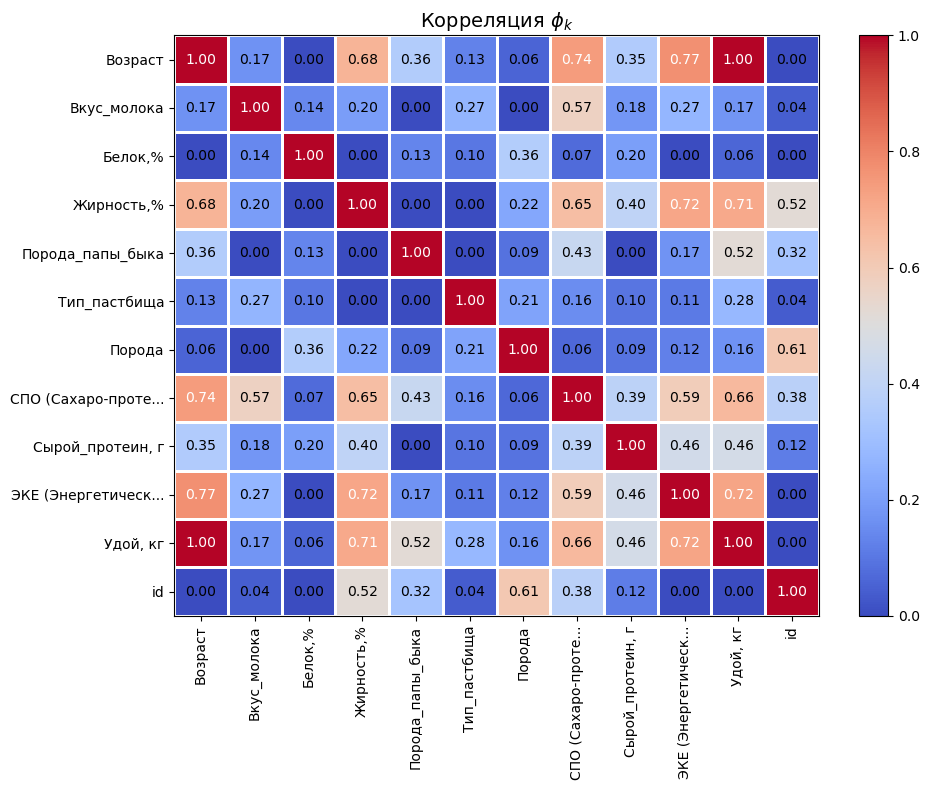

In [64]:
plot_correlation_matrix(phik_m.values, x_labels=phik_m.columns, y_labels=phik_m.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(10, 8))
plt.tight_layout()

 Исходя из матрицы корреляции $\phi_k$ можно сказать, что `Удой, кг` имеет сильную взаимосвязь с признаком `Возраст` = 1, с `Жирность,%` = 0.71, с `СПО (Сахаро-протеиновое соотношение)` = 0.66 и с `ЭКЕ (Энергетическая кормовая единица)` = 0.72.
       
Также можно ометить что `ЭКЕ (Энергетическая кормовая единица)` имеет взаимосвязь с признаками `Возраст` = 0.77, `Жирность,%` = 0.72 и `СПО (Сахаро-протеиновое соотношение)` = 0.59
    
`СПО (Сахаро-протеиновое соотношение)` имеет взаимосвзяь с признаком `Жирность,%` = 0.64 и `Возраст` = 0.74
    
`Жирность,%` имеет взаимосвязь с признаком `Возраст` = 0.68

Так как нашим целевым признаком является `Удой, кг` построим диаграммы рессеяния для него и всех количественных признаков с учётом значения категориальных признаков. Для удобства напишем функцию `scatter`.

<div class="alert alert-block alert-info">
    
Эту функцию тоже перенес в блок после импотра
    
</div>

In [65]:
# def scatter(data, y):
    # '''
    # функция строит диаграмму рассеяния для 
    # признака Удой при помощи библиотеки seaborn 
    
    # '''
    # sns.scatterplot(data=data, x="Удой, кг", y=y, hue='Порода')

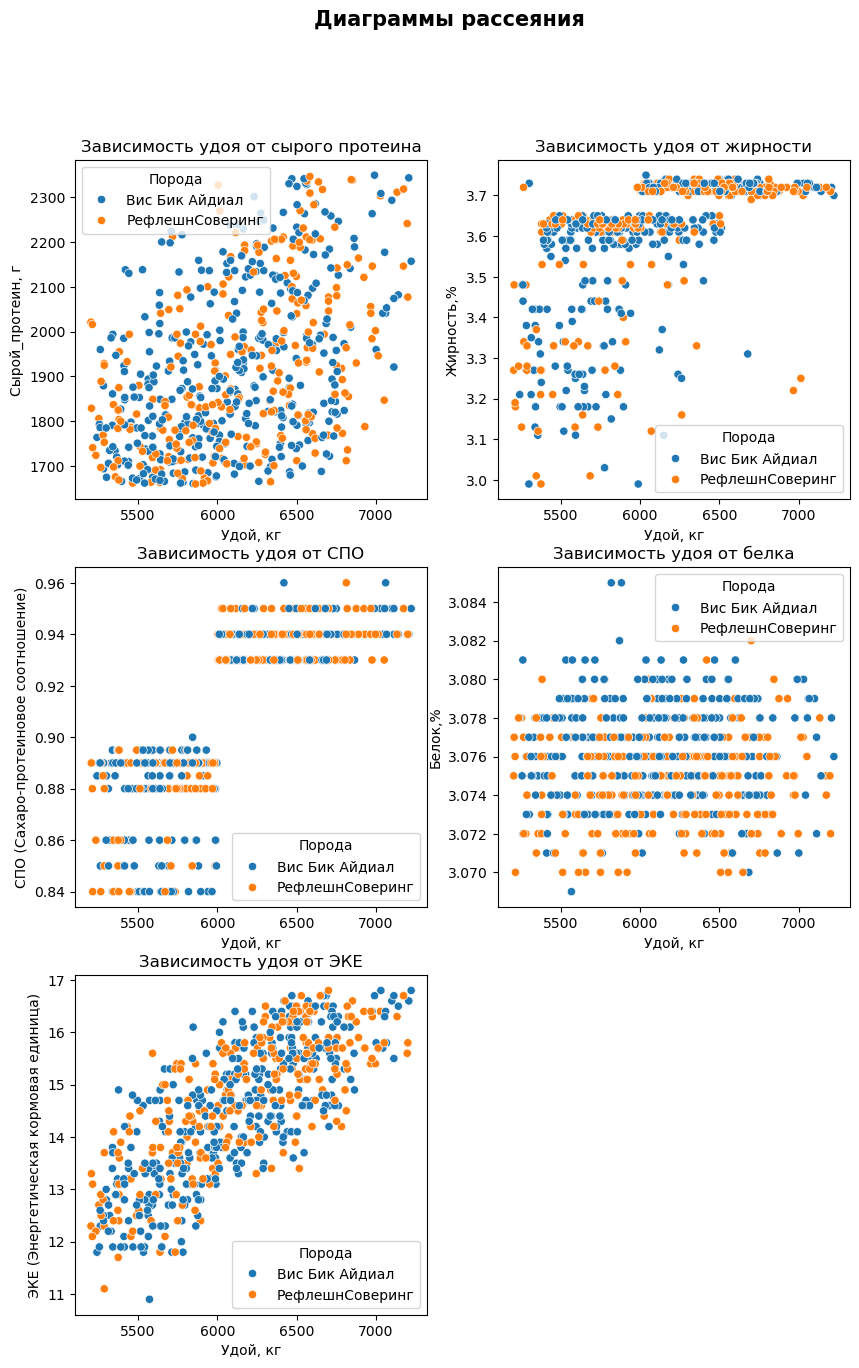

In [66]:
plt.figure(figsize=(10, 15))

plt.suptitle('Диаграммы рассеяния', fontsize=15, fontweight='bold')

plt.subplot(3, 2, 1)
sns.scatterplot(data=ferma_main, x='Удой, кг',
                y='Сырой_протеин, г', hue='Порода')
plt.title('Зависимость удоя от сырого протеина')

plt.subplot(3, 2, 2)
sns.scatterplot(data=ferma_main, x='Удой, кг',
                y='Жирность,%', hue='Порода')
plt.title('Зависимость удоя от жирности')

plt.subplot(3, 2, 3)
sns.scatterplot(data=ferma_main, x='Удой, кг',
                y='СПО (Сахаро-протеиновое соотношение)', hue='Порода')
plt.title('Зависимость удоя от СПО')

plt.subplot(3, 2, 4)
sns.scatterplot(data=ferma_main, x='Удой, кг',
                y='Белок,%', hue='Порода')
plt.title('Зависимость удоя от белка')

plt.subplot(3, 2, 5)
sns.scatterplot(data=ferma_main, x='Удой, кг',
                y='ЭКЕ (Энергетическая кормовая единица)', hue='Порода')
plt.title('Зависимость удоя от белка')
plt.title('Зависимость удоя от ЭКЕ');

1. По связи `Удой, кг` и `Сырой_протеин, г` видно, что линейной зависимости между ними нет. Говорить о нелинейной зависимости сложно.

2. По `Удой, кг` и `Жирность,%` анологичная ситуация, что и с `Сырой_протеин, г`, линейная зависимость не наблюдается. Похоже что они связаны между собой нелинейно. Похоже данные распределены по кластерам.

3. По `Удой, кг` и `СПО (Сахаро-протеиновое соотношение)` аналогичная ситуация, что и в предыдущих, но видно, что значения грубо говоря разделенны по классам, возможно стоит преобразовать данный признак категориальный. Скорее всего из-за этого имеется нелинейная зависимость.

4. По `Удой, кг` и `Белок,%`, линейной взаимосвязи между данными признаками нет. Но и также отсутсвет нелинейная

5. По `Удой, кг` и `ЭКЕ (Энергетическая кормовая единица)`, все еще такая же ситуация, но также наблюдается наклон графика, что может говорить о слабой линейной зависимости

## Вывод

В результате можно сделать следующие выводы:

1. Мультиколлинеарность между целевым и входными признаками не наблюдается
2. По корреляции Фи и была установлена связь удоя с ЭКЕ, СПО, Жирностью и Возрастом
3. По диаграммам рассеяния можно сказать, что удой связан нелинейной с СПО и Жирностью
4. Удой также имеет нелинейную взаимосвязь с ЭКЕ.
5. Установить какая взаимосвязь между удоем и протеином и белком довольно сложно.
5. Также стоит обратить внимание на Жирность, ее значения распределены по кластерам.
6. Возможно необходимо изменить некоторые признаки, например, СПО представить как категориальную переменную, а не количественную. Возможно стоит также поработать с ЭКЕ, так как его коэффициент корреляции второй повеличине.

# Обучение модели линейной регрессии

Приступим к обучению модели. Для нашего первого целевого признака `Удой, кг` воспользуемся линейной регрессией. Так как на данные могли влиять выбросы, то предпложим от каких признаков может зависить удой:
- На удой коров может влиять ее порода, так как у каждой породы свои особености и это также отражается на графиках в исследовательском анализе;
- Порода папы быка также может влиять на удой, так как от этого зависит, какая порода будет у самой коровы;
- Также на удой коров скорее всего влияет ее возраст и чем она старше, тем удой больше, что было заметно на графиках во время исследовательского анализа;
- Также стоит учесть характеристики корма, а именно необходимо учесть соотношение сахара и протеина, то есть СПО и показатель питательности корма, то есть ЭКЕ, это нужно для сбалансированного питания
- Также для сбалансированного питания важно соотношение сухого вещества, поэтому будет учитывать `Сырой_протеин, г`
- Предположим, что удой может зависить от типа пастбища, на каких питательных веществ больше на каких-то меньше это может влиять на удой

Для удобства обучения модели, написали функцию `linear_regres` с четыремя входными параметрами. Обучим нашу первую модель. 

Используем написанную нами функцию и в качестве входных признаков берем следующие:
- Категориальные: `Порода`, `Возраст`, `Порода_папы_быка` и `Тип_пастбища`
- Количественные: `Сырой_протеин, г`, `СПО (Сахаро-протеиновое соотношение)` и `ЭКЕ (Энергетическая кормовая единица)`

Наш целевой признак `Удой, кг`.

Оценивать модели будем по коэффициенту детерминации и по остаткам модели. Остатки модели показывают разницу между предсказанным и истинным значениями. А также по ним можно судить о качестве модели. По коэффициенту детерминации будем оценивать насколько хорошо модель предсказывает целевой признак по входным. 

Необходимо также оценить качество моделей по метрикам, а именно MSE (средня квадратичная ошибка), MAE (средняя абсолютная ошибка), RMSE ( корень средне квадратичной ошибки).

По остаткам модели:
- Случайность остатков модели: остатки должны быть нормально распределены, а их график — симметричен относительно самого частого значения;
- Устойчивость остатков модели: остатки должны иметь постоянную дисперсию на всём интервале использования модели.

In [67]:
# Для игнорирования предупреждений
warnings.simplefilter("ignore", FutureWarning)

Коэффициент детерминации = 0.6783030759233581
Средняя абсолютная ошибка = 184.35031847133757
Среднеквадратичная ошибка = 65486.2229299363
Корень среднеквадратичной ошибки = 255.90276069229168
Доверительный интервал = (6090.104130090581, 6240.328990928528)


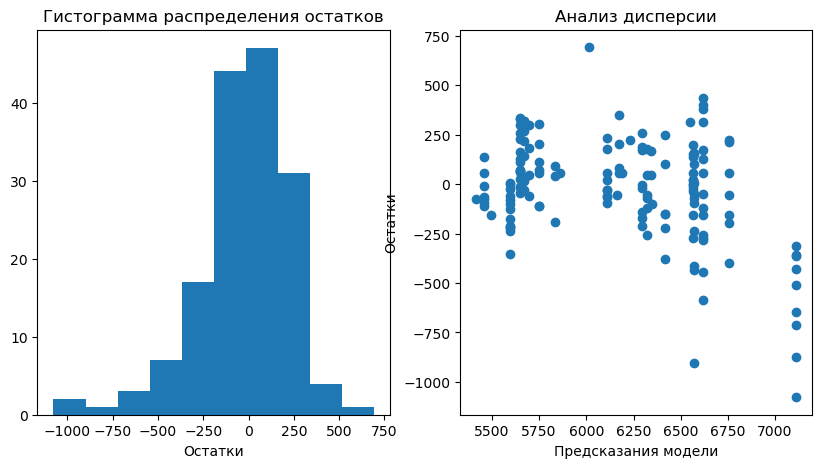

In [68]:
X = ferma_main.drop(['Удой, кг'], axis=1)
y = ferma_main['Удой, кг']

cat_col_names = ['Порода',
                 'Возраст',
                 'Порода_папы_быка',
                 'Тип_пастбища']
num_col_names = ['Сырой_протеин, г',
                 'СПО (Сахаро-протеиновое соотношение)',
                 'ЭКЕ (Энергетическая кормовая единица)']

model_lr_1, scaler_1, encoder_1 = (
    linear_regres(
        X,
        y,
        cat_col_names,
        num_col_names,
        RANDOM_STATE)
)

По данным результатам можно сказать, что в `67%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

По анализу остатков можно сказать:
- Случайность остатков модели, имеет скошеное влево нормальное распределение.
- Устойчивость остатков модели, имеет непостоянную дисперсию

`MAE` показывает, что в среднем на `184.35 кг` предсказания отличаются от истинного значения

`MSE` показывает, что в среднем на `65486.2 кг^2` предсказания отличаются от истинного значения

`RMSE` показывает, что в среднем на `255.9 кг` предсказания отличаются от истинного значения

Попробуем улучшить модель и избавимся от нелинейности в `СПО`, то есть преобразуем `СПО` в категориальный бинарный признак. Также для появления линейной зависимости между Удоем и ЭКЕ, необходимо ввести новый признак ЭКЕ в квадрате.

Добавим новый признак в датафрейм, то есть возведем все значения в столбце `ЭКЕ (Энергетическая кормовая единица)` в квадрат

In [69]:
# Возводим значения в квадрат
ferma_main['ЭКЕ^2'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)'] ** 2

Посотрим появились ли изменения, выведем первые 5 строчек нового признака.

In [70]:
ferma_main['ЭКЕ^2'].head()  # Выводим первые пять значений

0    201.64
1    163.84
2    196.00
3    153.76
4    163.84
Name: ЭКЕ^2, dtype: float64

Сделаем `СПО` категориальным признаком. Исходя из имеющихся у нас данных. `СПО` принимает значение от 0.8 и до 1. Как можно заметить по диаграммам рассеяния часть данных ниже 0.9, часть выше. Следовательно границу разделения данных можно ставить равной 0.9, те значения, которые ниже данной границы обозначим как 0, а выше 1.

In [71]:
ferma_main.loc[ferma_main['СПО (Сахаро-протеиновое соотношение)']
               > 0.9, 'СПО (Сахаро-протеиновое соотношение)'] = 1

In [72]:
ferma_main.loc[ferma_main['СПО (Сахаро-протеиновое соотношение)']
               < 0.9, 'СПО (Сахаро-протеиновое соотношение)'] = 0

Добавим наши новые признаки и обучим еще одну модель при помощи нашей функции `linear_regres`

Коэффициент детерминации = 0.7606343571054806
Средняя абсолютная ошибка = 167.88535031847132
Среднеквадратичная ошибка = 48726.458598726116
Корень среднеквадратичной ошибки = 220.74070444466312
Доверительный интервал = (6091.396817845283, 6233.928022919048)


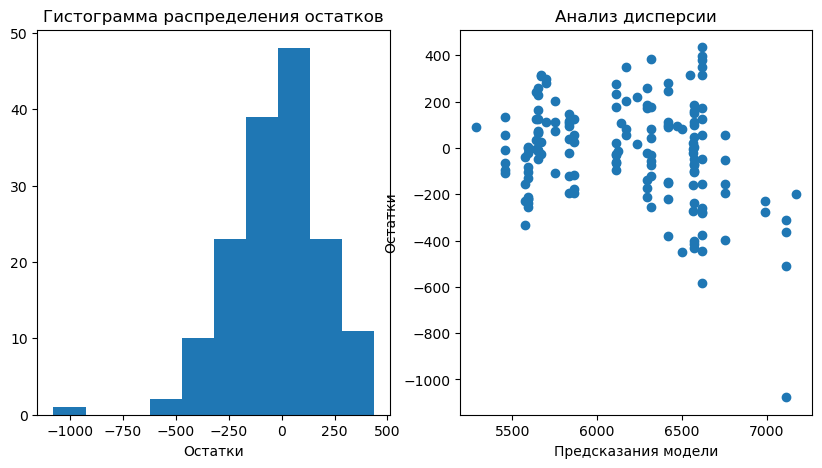

In [73]:
X = ferma_main.drop('Удой, кг', axis=1)
y = ferma_main['Удой, кг']

cat_col_names = ['Порода',
                 'Возраст',
                 'Порода_папы_быка',
                 'СПО (Сахаро-протеиновое соотношение)',
                 'Тип_пастбища']
num_col_names = ['Сырой_протеин, г',
                 'ЭКЕ^2',
                 'ЭКЕ (Энергетическая кормовая единица)']

model_lr_2, scaler_2, encoder_2 = (
    linear_regres(
        X,
        y,
        cat_col_names,
        num_col_names,
        RANDOM_STATE)
)

В результате получаем, что в `76%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

По анализу остатков можно сказать:
- Случайность остатков модели, имеет смещеное влево нормальное распределение.
- Устойчивость остатков модели, имеет постоянную дисперсию

`MAE` показывает, что в среднем на `167.9 кг` предсказания отличаются от истинного значения

`MSE` показывает, что в среднем на `48726.4 кг^2` предсказания отличаются от истинного значения

`RMSE` показывает, что в среднем на `220.7 кг` предсказания отличаются от истинного значения

Добавим новый признак и обучим третью модель. Добавим признак `Имя_папы` из датафрейма `ferma_dad`. 

Выведем размерность нашего основного датафрейма

In [74]:
ferma_main.shape  # Выводим размерность

(628, 13)

Соединяем два датафрейма по столбцу `id` и сохраняем в переменной `ferma_main_dad`

In [75]:
ferma_main_dad = ferma_main.merge(ferma_dad, on='id', how='outer')

Проверим правильно ли склеились данные, в результате должно остаться столько же строк и добавится 1 новый столбец

In [76]:
ferma_main_dad.shape  # Выводим размерность

(628, 14)

Данные были успешно объединены

Обучим третью модель.

Коэффициент детерминации = 0.7331029029371885
Средняя абсолютная ошибка = 174.19745222929936
Среднеквадратичная ошибка = 54330.89808917198
Корень среднеквадратичной ошибки = 233.0898927220397
Доверительный интервал = (6061.315264613389, 6197.372633475783)


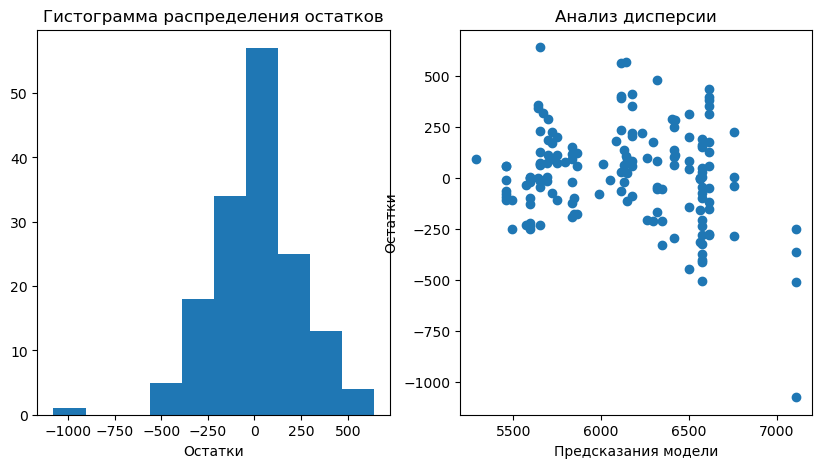

In [77]:
X = ferma_main_dad.drop('Удой, кг', axis=1)
y = ferma_main_dad['Удой, кг']

cat_col_names = ['Порода',
                 'Возраст',
                 'Порода_папы_быка',
                 'СПО (Сахаро-протеиновое соотношение)',
                 'Имя_папы',
                 'Тип_пастбища']
num_col_names = ['Сырой_протеин, г',
                 'ЭКЕ^2',
                 'ЭКЕ (Энергетическая кормовая единица)']

model_lr_3, scaler_3, encoder_3 = (
    linear_regres(
        X,
        y,
        cat_col_names,
        num_col_names,
        RANDOM_STATE)
)

В результате получаем, что в `73%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

По анализу остатков можно сказать:
- Случайность остатков модели, имеет смещеное влево нормальное распределение.
- Устойчивость остатков модели, имеет постоянную дисперсию

`MAE` показывает, что в среднем на `174.2 кг` предсказания отличаются от истинного значения

`MSE` показывает, что в среднем на `54330.9 кг^2` предсказания отличаются от истинного значения

`RMSE` показывает, что в среднем на `233.1 кг` предсказания отличаются от истинного значения

По результатам можно сказать, что лучшей моделью является вторая. Так как она по всем метрикам лучше, чем другие. Её 95%-ый доверительный интервал равен (6091.39, 6233.92). Это означает, что только 5%-ная вероятность того, что истинное среднее значение генеральной совокупности лежит за пределами 95%-го доверительного интервала. То есть существует только 5% вероятность того, что истинный средний удой коровы меньше 6091.39 кг или больше 6233.92 кг.

С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить. Данные о них находятся в датасете `cow_buy`

Для начала необходимо добавить недостающие признаки `ЭКЕ (Энергетическая кормовая единица`), `Сырой_протеин, г` и `СПО (Сахаро-протеиновое соотношение)` мы возьмем их из датасета `ferma_main` и увеличим их на 5% , так как технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.

In [78]:
cow_buy['ЭКЕ (Энергетическая кормовая единица)'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)'].median() * 1.05

In [79]:
# Возводим значения в квадрат
cow_buy['ЭКЕ^2'] = cow_buy['ЭКЕ (Энергетическая кормовая единица)'] ** 2

In [80]:
cow_buy['Сырой_протеин, г'] = ferma_main['Сырой_протеин, г'].median() * 1.05

In [81]:
cow_buy['СПО (Сахаро-протеиновое соотношение)'] = ferma_main['СПО (Сахаро-протеиновое соотношение)'].median() * 1.05

In [82]:
cow_buy.loc[cow_buy['СПО (Сахаро-протеиновое соотношение)']
            > 0.9, 'СПО (Сахаро-протеиновое соотношение)'] = 1

Выполним подготовку данных для нашего датафрейма `cow_buy` и используем нашу первую модель `model_lr_3` для предсказания `Удой, кг`.

In [83]:
X = cow_buy

cat_col_names = ['Порода',
                 'Возраст',
                 'Порода_папы_быка',
                 'СПО (Сахаро-протеиновое соотношение)',
                 'Тип_пастбища']
num_col_names = ['Сырой_протеин, г',
                 'ЭКЕ^2',
                 'ЭКЕ (Энергетическая кормовая единица)']

# Подготовка признаков для масштабирования и кодирования
# Трансформируем количественные признаки
X_scaled = scaler_2.transform(X[num_col_names])

# Трансформируем категориальные признаки
X_ohe = encoder_2.transform(X[cat_col_names])

# Получаем список новых столбцов и сохраняем его в новой переменой
encoder_col_names = encoder_2.get_feature_names_out()

# Создаём датафрейм из закодированных и отмасштабированных данных
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

# Объединяем все преобразованные данные
X = pd.concat([X_ohe, X_scaled], axis=1)

# Получение предсказаний
predictions = model_lr_2.predict(X)

# Выводим предсказанные значения
predictions

array([7113, 5594, 6112, 6617, 6755, 5594, 7113, 6112, 6112, 5456, 6112,
       6112, 7113, 5417, 6112, 6617, 6112, 5594, 6112, 6755], dtype=int64)

# Обучение модели логистической регрессии

Наш следующий целевой признак `Вкус молока` для него необходимо обучить моель логистической регрессии.

Нам необходимо столбец `Вкус_молока` преобразовать в метки класса, то есть значение `вкусно` будет `0`, а `не вкусно` будет `1`. Так как в логистической регресии целевой признак передается в виде метки класса.

In [84]:
# Меняем значение в столбце Вкус молока на метки класса
ferma_main_dad['Вкус_молока'] = (
    ferma_main_dad['Вкус_молока']
    .replace('вкусно', 0)
    .replace('не вкусно', 1)
)

Наш целевой признак `Вкус_молока`. Входными признаками будут следующие. Предположим, что скорее всего `Вкус_молока` зависит от содержания белка и жиров, то есть берем `Белок,%` и `Жирность,%`. Также вкус может зависить от `Порода` коровы и ее папы `Порода_папы_быка` и его имени `Имя_папы`, от ее `Возраст`. Также важны характеристики корма, чтобы молоко получилось сбалансированым: `Сырой_протеин, г`, `СПО (Сахаро-протеиновое соотношение)`, `ЭКЕ (Энергетическая кормовая единица)` и `ЭКЕ^2`. Также следует учесть `Тип_пастбища`.

Также как было видно из корреляционног анализа, признак `Жирность,%` на графике разделен на три кластера, что дает нам право перватить его в категориальную переменную: до 3.45 низкая, средняя до 3.68 и высокая больше 3.68.
    
    
Для этого воспользуемся, написанной нами функцией `fat_content`

In [85]:
ferma_main_dad['Жирность,%'] = ferma_main_dad['Жирность,%'].apply(fat_content)

In [86]:
X = ferma_main_dad.drop(columns=['Вкус_молока'])
y = ferma_main_dad['Вкус_молока']

cat_col_names = ['Порода', 
                 'Возраст',
                 'СПО (Сахаро-протеиновое соотношение)',
                 'Жирность,%',
                 'Тип_пастбища',
                 'Порода_папы_быка',
                 'Имя_папы']
num_col_names = ['Белок,%',
                 'Сырой_протеин, г',
                 'ЭКЕ (Энергетическая кормовая единица)',
                 'ЭКЕ^2']  

In [87]:
# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y)

In [88]:
# Подготовка признаков для масштабирования и кодирования
# Создаем переменную с экземпляром класса StandardScaler
scaler = StandardScaler()

# Обучаем и трансформируем количественные признаки из тренировчнй выборки
# и преобразуем количественные признаки в тестовой выборке
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Создаем переменную с экземпляром класса OneHotEncoder с избеганием дамми-ошибок
encoder = OneHotEncoder(drop='first', sparse=False)

# Обучаем и трансформируем категориальные признаки из тренировчнй выборки
# и преобразуем категориальные признаки в тестовой выборке
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

# Получаем список новых столбцов и сохраняем его в новой переменой
encoder_col_names = encoder.get_feature_names_out()

In [89]:
# Cоздаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
# Объединяем все преобразованные данные
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [90]:
# Обучение модели и получение предсказаний на тестовых данных
clf = LogisticRegression(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy:  0.605
recall:  0.368
precision:  0.568


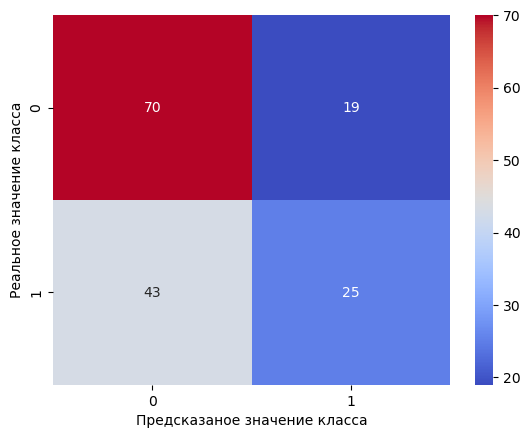

In [91]:
# Рассчитывакм accuracy, recall и precision
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Выводим метрики
print('accuracy: ', round(acc, 3))
print('recall: ', round(recall, 3))
print('precision: ', round(precision, 3))

# Строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('Реальное значение класса')
plt.xlabel('Предсказаное значение класса');

Можно сделать предварительные выводы. Мы получили, что доля верных ответов модели равна `62%`, наш `precision` равен `60%`, `recall` равняется `38%`. Получается, что наша модель чаще избегает ошибки первого рода `60%` против `38%`.

Так как для фермера важен вкус молока, то нам важны ошибки первого рода, то есть `precision`.  В нашем случае ошибки второго рода, когда модель может предсказать не вкусное молоко, хотя на самом деле оно вкусное, для фермера это не критично, так как он просто не станет брать такую корову и не потеряет деньги. А вот ошибки первого рода будут критичны, так как, если модель расценит не вкусное молоко, как вкусное, тогда фермер понесет убытки. В нашем случае модель ошибочно предсказывает не вкусное молоко как вкусное в 17 случаях.

Получается нам необходимо сделать`precision` как можно больше.

Сейчас модель допускает ошибку первого рода в 17 случаях. Подберем порог, чтобы свести эти ошибки к минимуму. Для этого вспользуемся методом `predict_proba` и создадим таблицу с отсортированными предсказаниями.

Добавим пороги и посмотрим как модель будет работать при 13 разных порогах

In [92]:
y_proba = clf.predict_proba(X_test)[:, 1]

data = pd.DataFrame(zip(y_test, y_proba),
                    columns=['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)

In [93]:
# Разделяем промежуток на более мелкие
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=12, endpoint=False)]

In [94]:
# Создаём переменную, которая будет хранить список новых колонок
columns = []

# Добаваляем столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_' +
         str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

# Выведем 5 случайных строк
print(data.sample(5))

     y_valid   y_proba  y_pred_0.1  y_pred_0.18  y_pred_0.25  y_pred_0.32  \
25         1  0.690658           1            1            1            1   
126        1  0.589805           1            1            1            1   
63         1  0.452048           1            1            1            1   
39         0  0.288106           1            1            1            0   
119        0  0.625265           1            1            1            1   

     y_pred_0.4  y_pred_0.48  y_pred_0.55  y_pred_0.62  y_pred_0.7  \
25            1            1            1            1           0   
126           1            1            1            0           0   
63            1            0            0            0           0   
39            0            0            0            0           0   
119           1            1            1            1           0   

     y_pred_0.77  y_pred_0.85  y_pred_0.92  
25             0            0            0  
126            0          

Возможно в данном случае лучший порог - `0.7`, убедимся в этом, построя матрицу ошибок.

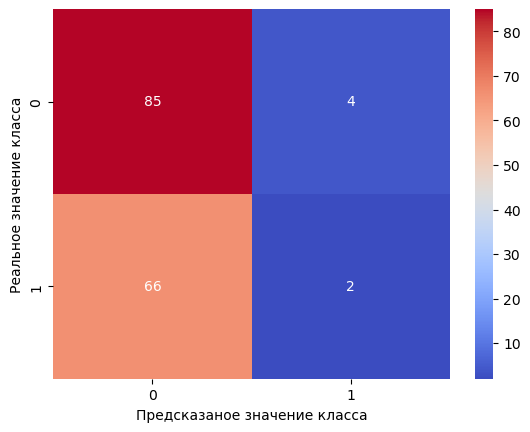

In [95]:
# Строим матрицу ошибок
cm = confusion_matrix(y_test, data['y_pred_0.7'])
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('Реальное значение класса')
plt.xlabel('Предсказаное значение класса');

Видно, что при таком пороге модель соврешает ошибки первого рода в 3 случаях. Увеличим порог, чтобы свести эти ошибки к 0.

Возьмем следующий порог по величине, то есть 0.77 и выведем матрицу ошибок

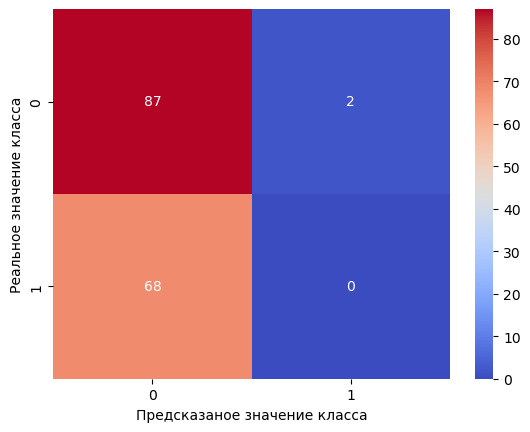

In [96]:
# Строим матрицу ошибок
cm = confusion_matrix(y_test, data['y_pred_0.77'])
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('Реальное значение класса')
plt.xlabel('Предсказаное значение класса');

При таком пороге модель не совершает ошибок первого рода, значит наш лучший порог - `0.77`

Нам также необходимо сделать жирность котегориальной переменной в датафрейме `cow_buy`

In [97]:
cow_buy['Текущая_жирность,%'] = cow_buy['Текущая_жирность,%'].apply(
    fat_content)

Теперь с помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить.

In [98]:
cow_buy = cow_buy.rename(columns ={'Текущий_уровень_белок,%': 'Белок,%', 'Текущая_жирность,%': 'Жирность,%'})

In [99]:
X_reg = cow_buy

cat_col_names = ['Порода',
                 'Возраст',
                 'СПО (Сахаро-протеиновое соотношение)',
                 'Жирность,%',
                 'Тип_пастбища',
                 'Порода_папы_быка',
                 'Имя_папы']
num_col_names = ['Белок,%',
                 'Сырой_протеин, г',
                 'ЭКЕ (Энергетическая кормовая единица)',
                 'ЭКЕ^2']

# Подготовка признаков для масштабирования и кодирования
# Трансформируем количественные признаки
X_scaled_reg = scaler.transform(X_reg[num_col_names])

# Трансформируем категориальные признаки
X_ohe_reg = encoder.transform(X_reg[cat_col_names])

# Получаем список новых столбцов и сохраняем его в новой переменой
encoder_col_names_reg = encoder.get_feature_names_out()

# Создаём датафрейм из закодированных и отмасштабированных данных
X_ohe_reg = pd.DataFrame(X_ohe_reg, columns=encoder_col_names_reg)
X_scaled_reg = pd.DataFrame(X_scaled_reg, columns=num_col_names)

# Объединяем все преобразованные данные
X_reg = pd.concat([X_ohe_reg, X_scaled_reg], axis=1)

# Получение оценок принадлежности к классу
y_proba_reg = clf.predict_proba(X_reg)[:, 1]

# Сделаем предикт, используя найденый порог
predict = np.vectorize(lambda x: 1 if x >= 0.77 else 0)
predicts = predict(y_proba_reg)

# Выводим оценки
predicts

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

Полученные спрогнозированные результаты добавим в датафрейм `cow_buy`.

In [100]:
cow_buy['Удой, кг_прог'] = predictions  # Добавляем в датафрейм прогноз по Удою

In [101]:
# Добавляем в датафрейм прогноз по вкусу
cow_buy['Вкус_молока_прог'] = predicts

In [102]:
# Меняем значение в столбце Вкус молока
cow_buy['Вкус_молока_прог'] = (
    cow_buy['Вкус_молока_прог']
    .replace(0, 'вкусно')
    .replace(1, 'не вкусно')
)

Выведем первые 5 значение датафрейма

In [103]:
cow_buy.sort_values(by='Удой, кг_прог', ascending=False).head(
    10)  # Выводим датафрейм и сортируем по убыванию

,Порода,Тип_пастбища,Порода_папы_быка,Имя_папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ^2,"Сырой_протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг_прог",Вкус_молока_прог
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,Средняя,3.076,более_2_лет,15.435,238.239225,1982.4,1.0,7113,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,Средняя,3.046,более_2_лет,15.435,238.239225,1982.4,1.0,7113,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,Средняя,3.076,более_2_лет,15.435,238.239225,1982.4,1.0,7113,вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,Средняя,3.074,более_2_лет,15.435,238.239225,1982.4,1.0,6755,вкусно
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,Средняя,3.074,более_2_лет,15.435,238.239225,1982.4,1.0,6755,вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,Низкая,3.061,более_2_лет,15.435,238.239225,1982.4,1.0,6617,вкусно
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,Низкая,3.065,более_2_лет,15.435,238.239225,1982.4,1.0,6617,вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,Средняя,3.079,более_2_лет,15.435,238.239225,1982.4,1.0,6112,вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,Средняя,3.074,более_2_лет,15.435,238.239225,1982.4,1.0,6112,вкусно
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,Высокая,3.073,более_2_лет,15.435,238.239225,1982.4,1.0,6112,вкусно


# Итоговые выводы

Данные были получены из трёх файлов:
- `ferma_main.csv`
- `ferma_dad.csv`
- `cow_buy.csv`

Сначала был сделан обзор данных. Само исследование проходило в четыре этапа:
- Изучить данные;
- Предобработка данных;
- Исследовательский анализ данных;
- Корреляционный анализ;
- Обучение модели.

**1. Обзор данных**

В самом начале столкнулись с проблемой склеивания данных в одну строку.

- В таблице `ferma_main` 12 столбцов, тип данных - `int`(3), `object`(9). Количестов значений в столбцах одинаковое, а значит пропусков нет. В столбцах  `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, и `Белок,%` следует поменть тип данных на `float`. Название столбцов `Сырой протеин`, `Тип пастбища`, `порода папы_быка`, `Вкус молока` не соотвествует стилю;
- В таблице `ferma_dad`2 столбца, тип данных - `int`(1), `object`(1). Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбца `Имя Папы` не соотвествует стилю;
- В таблице `cow_buy` 7 столбцов, тип данных - `object`(7). Количестов значений в столбцах одинаковое, а значит пропусков нет. В столбцах `Текущая_жирность,%` и `Текущий_уровень_белок,%` следует поменять тип данных на `float`. Также следует поменять название столбцов, чтобы они соотвествовали стилю `Тип пастбища`, `порода папы_быка`.

**2. Предобработка данных**

Переименовали столбцы в датафреймах:
- Перемеиновали столбцы в датаферейме `farma_main`:
    - `Сырой протеин, г` на `Сырой_протеин, г`;
    - `Тип пастбища` на `Тип_пастбища`;
    - `порода папы_быка` на `Порода_папы_быка`;
    - `Вкус молока` на `Вкус_молока`.
- Перемеиновали столбец в датаферейме `farma_dad`:
    - `Имя Папы` на `Имя_папы`.
- Перемеиновали столбцы в датаферейме `cow_buy`:
    - `Тип пастбища` на `Тип_пастбища`;
    - `порода папы_быка` на `Порода_папы_быка`.

Проверили типы данных в датафреймах и поменяли их, где было необходимо:
- Поменяли тип данных в датафрейме `farma_main` с `object` на `float` в следующих столбцах:
    - `ЭКЕ (Энергетическая кормовая единица)`;
    - `СПО (Сахаро-протеиновое соотношение)`;
    - `Жирность,%`;
    - `Белок,%`
- Поменяли тип данных в датафрейме `cow_buy` с `object` на `float` в следующих столбцах:
    - `Текущая_жирность,%`;
    - `Текущий_уровень_белок,%`.

Изучили дубликаты в датафреймах:
- Удалили явные дубликаты в датафрейме `farma_main` в количестве 5 штук;
- Нашли явные дубликаты в датафрейме `cow_buy` в количестве 4 штук, но не стали их удалять, так как они категориальные, их немного - вероятность повторо высокая, поэтому оставили дубли. Кроме того, фермер предполагает получить результат выбора из 20 коров.
- В датафрейме `farma_dad` сделали проверку на явные дубликаты -  не обнаружели;
- В датафрейме `farma_main` были найдены неявные дубликаты:
    - В столбце `Тип пастбища` изменили название `Равнинные`  на `Равниное`; 
    - В столбце `Порода_папы_быка` изменили название `Айдиалл` на `Айдиал`.
-  В столбце `Тип пастбища` датафрейма `cow_buy` сделали начало названий пастбищ с верхнего регистра;

Сделали проверку всех датафреймов на пропуски - не обнаружели.

**3. Исследовательский анализ данных**

1. Изучили и визуализировали при помощи круговой диаграммы соотношение коров по возрасту. В результате в стаде фермера преобладают коровы старше 2 лет 82.5% от общего числа.

2. Изучили и визуализировали при помощи круговой диаграммы соотношение пород в стаде фермера. В результате в стаде фермера коров породы `Вис Бик Айдиал` больше и составляет 59.3%, чем `РефлешнСоверинг` 40.7%.

3. Изучили и визуализировали при помощи круговой диаграммы соотношение пастбищ, на которых пасутся коровы. В результате в стаде фермера 55.8% коров пасутся на холмисты пастбищах.

4. Изучили и визуализировали при помощи круговой диаграммы соотношение породы папы быков. В результате в стаде фермера коровы от породы разных быков практически одинакокое количество.

5. Изучили и визуализировали при помощи круговой диаграммы соотношение имен быков. В результате в стаде фермера преоблдают имена быков `Барин` - 38.2% и `Буйный` - 34.1%.

6. Изучили и визуализировали при помощи круговой диаграммы соотношение имен пап быков коров, которых хочет купить фермер. В результате в Экоферме преоблдают имена быков `Буйный` - 40% и `Геркулес` - 30%.

7. Изучили и визуализировали при помощи круговой диаграммы соотношение прод коров, которых хочет купить фермер. В результате В стаде Экофермы преобладают коровы породы `РефлешнСоверинг` - 55%.

8. Изучили и визуализировали при помощи круговой диаграммы соотношение тип пастбищ на которых пасуться коровы, которых хочет купить фермер. В стаде Экофермы преобладают коровы, которые послись на равнинных пастбищах - 55%.

9. Изучили и визуализировали при помощи круговой диаграммы соотношение возраста коров, которых хочет купить фермер. В стаде Экофермы преобладают коровы старше 2 лет и составляют 75% от всего стада.

Провели статистический анализ всех признаков.

1. В стаде Экофермы информация по текущему уровню белка был найден 1 выброс, он не выглядит аномальным и мы не удаляем его;
2. Самый частый уровень белка 3.075% судя по информации по коровам из Экофермы;
3. Все графики по всем количественным признакам скошены вправо;
4. По `Удой. кг` было найдено аномальное значение, которое было удалено, оно сильно влияло на результаты;
5. Были найдены не значительные выбросы по уровню белка и жирности их не стали удалять, они не влияли на результат;
6. Все графики по всем количественным признакам имеют ненормальное мультимодальное распределние
7. Вкус молока скорее всего зависит от типа пастбища и возраста коровы.
8. Удой молока скорее всего зависит от породы коровы.

Вывод по исследовательскому анализу: для улучшения данных можно удалить выбросы. Либо же добавить больше таких выбросов, для того, чтобы модель могла с работать с такими данными. Также необходимо выяснить у каких признаков между собой имеется линейная зависимость.

**4. Корреляционный анализ**

Изучили взаимосвязь между признаками, то есть рассчитали коэффициенты корреляции Фик между всеми признаками. В результате получили, что что `Удой, кг` имеет сильную взаимосвязь с признаком `Возраст` = 1, с `Жирность,%` = 0.71, с `СПО (Сахаро-протеиновое соотношение)` = 0.66 и с `ЭКЕ (Энергетическая кормовая единица)` = 0.72. Также можно ометить что `ЭКЕ (Энергетическая кормовая единица)` имеет взаимосвязь с признаками `Возраст` = 0.77, `Жирность,%` = 0.72 и `СПО (Сахаро-протеиновое соотношение)` = 0.59. Признак `СПО (Сахаро-протеиновое соотношение)` имеет взаимосвзяь с признаком `Жирность,%` = 0.64 и `Возраст` = 0.74. Признак `Жирность,%` имеет взаимосвязь с признаком `Возраст` = 0.68

Построили диаграммы рассеяния для признака `Удой, кг` и всех количественных признаков с учётом значения категориальных признаков.

В результате можно сделать следующие выводы:

По результатам корреляционного анализа были сделаны следующие выводы:

1. Мультиколлинеарность между целевым и входными признаками не наблюдается;
2. По корреляции Фи и была установлена связь удоя с `ЭКЕ`, `СПО`, `Жирностью` и `Возрастом`;
3. По диаграммам рассеяния можно сказать, что удой связан нелинейной с `СПО` и `Жирностью`;
4. Удой также имеет нелинейную взаимосвязь с `ЭКЕ`;
5. Установить какая взаимосвязь между удоем и протеином и белком довольно сложно;
6. Также стоит обратить внимание на Жирность, ее значения распределены по кластерам.
7. Предположили, что возможно необходимо изменить некоторые признаки, например, `СПО` представить как категориальную переменную, а не количественную. Также возможно стоит добавить больше больших значений. Возможно стоит также поработать с `ЭКЕ`, так как его коэффициент корреляции второй повеличине.

**5. Обучение модели**

Необходимо было спрогнозировать два целвых признака `Удой, кг` и `Вкус_молока`.

Для нашего первого целевого признака `Удой, кг` воспользуемся линейной регрессией. Так как на данные могли влиять выбросы, то предпложили от каких признаков может зависить удой:
- На удой коров может влиять ее порода, так как у каждой породы свои особености и это также отражается на графиках в исследовательском анализе;
- Порода папы быка также может влиять на удой, так как от этого зависит, какая порода будет у самой коровы;
- Также на удой коров скорее всего влияет ее возраст и чем она старше, тем удой больше, что было заметно на графиках во время исследовательского анализа;
- Также стоит учесть характеристики корма, а именно необходимо учесть соотношение сахара и протеина, то есть СПО и показатель питательности корма, то есть ЭКЕ, это нужно для сбалансированного питания
- Также для сбалансированного питания важно соотношение сухого вещества, поэтому будет учитывать `Сырой_протеин, г`

В результате обучили 3 модели и выбрали из них лучшую, для удобствов расчетов была написана функция `linear_regres`. Все 3 модели оценивали по коэффициенту детерминации, по остаткам модели, MSE (средня квадратичная ошибка), MAE (средняя абсолютная ошибка), RMSE ( корень средне квадратичной ошибки), а также выводили 95%-ый довертильный диапазон прогноза. 

Результаты первой модели: 
- в `67%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.`MAE` показывает, что в среднем на `184.35 кг` предсказания отличаются от истинного значения. `MSE` показывает, что в среднем на `65486.2 кг^2` предсказания отличаются от истинного значения. `RMSE` показывает, что в среднем на `255.9 кг` предсказания отличаются от истинного значения

- По анализу остатков можно сказать:
    - Случайность остатков модели, имеет скошеное влево нормальное распределение.
    - Устойчивость остатков модели, имеет непостоянную дисперсию.

Для второй модели, избавились от нелинейности в `СПО`, то есть преобразовали `СПО` в категориальный бинарный признак. Также для появления линейной зависимости между `Удоем` и `ЭКЕ`, возвели ЭКЕ в квадрат.

Результаты второй модели:

- В `76%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака. `MAE` показывает, что в среднем на `167.9 кг` предсказания отличаются от истинного значения. `MSE` показывает, что в среднем на `48726.4 кг^2` предсказания отличаются от истинного значения. `RMSE` показывает, что в среднем на `220.7 кг` предсказания отличаются от истинного значения

- По анализу остатков можно сказать:
    - Случайность остатков модели, имеет смещеное влево нормальное распределение.
    - Устойчивость остатков модели, имеет постоянную дисперсию

Для третьей модели добавили новый признак `Имя_папы` из датафрейма `ferma_dad`. 

Результаты третье модели:

- в `73%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака. `MAE` показывает, что в среднем на `174.2 кг` предсказания отличаются от истинного значения. `MSE` показывает, что в среднем на `54330.9 кг^2` предсказания отличаются от истинного значения. `RMSE` показывает, что в среднем на `233.1 кг` предсказания отличаются от истинного значения

- По анализу остатков можно сказать:
    - Случайность остатков модели, имеет смещеное влево нормальное распределение.
    - Устойчивость остатков модели, имеет постоянную дисперсию.

Её 95%-ый доверительный интервал равен (6091.39, 6233.92). Это означает, что только 5%-ная вероятность того, что истинное среднее значение генеральной совокупности лежит за пределами 95%-го доверительного интервала. То есть существует только 5% вероятность того, что истинный средний удой коровы меньше 6091.39 кг или больше 6233.92 кг.

В результате лучшей моделью приняли вторую модель и с её помощью был спрогнозирован удой.

Наш второй целевой признак `Вкус молока` для него необходимо обучить моель логистической регрессии. Поменяли в столбце `Вкус_молока` значение `вкусно` на `0`, а `не вкусно` на `1`.

Предположили какими могут быть входные признаки и выбрали их. Предположили, что `Вкус_молока` зависит от содержания белка и жиров, то есть берем `Белок,%` и `Жирность,%`. Также вкус может зависить от `Порода` коровы и ее папы `Порода_папы_быка` и его имени `Имя_папы`, а также от ее `Возраст`. Также важны характеристики корма, чтобы молоко получилось сбалансированым: `Сырой_протеин, г`, `СПО (Сахаро-протеиновое соотношение)` и `ЭКЕ (Энергетическая кормовая единица)` и `ЭКЕ^2`. Также следует учесть `Тип_пастбища`.

Исходя из резултатов корреляционного анализа, признак `Жирность,%` переобразовали в котегориальный: до 3.45 низкая, средняя до 3.68 и высокая больше 3.68.

Для оценивания результатов модели использовали: `accuracy`, `recall`, `precision` и матрицу ошибок. В результате получили, что доля верных ответов модели равна `62%`, наш `precision` равен `60%`, `recall` равняется `38%`. Наша модель чаще избегает ошибки первого рода `67%` против `36%`.

Посчитали, что для задачи фермера важнее ошибки первого рода, то есть `precision` и ее мы максимизировали. Для улучшения качества модели вспользовались методом `predict_proba` и подобрали лучший порог. В данном случае лучший порог - `0.77`. 

По полученой модели предсказали вкус молока. И добавили оба наших спрогнозированых значения в датафрейм `cow_buy`.

Результат регрессионной модели я думаю можно улучшить, сделав данные по которым она обучается лучше, то есть либо же добавить больше значений выбивающихся, либо же убрать выбивающиеся значения, но тогда, если такие значения появятся, то модель будет плохо с ними рабоать. Также можно уточнить у фермера, какие признаки больше всего влияют на качество молока.

Для моделей классификации, в том числе логистической регрессии, важны такие метрики как `recall`, `precision`. В зависимости от задач будет важна та или иная метрика. Первая отвечает за ошибки второго рода, вторая за ошибки первого рода. Также стоит отметить матрицу ошибок, хоть она и не является метрикой, но с помощью нее можно понять сколько значений попдают в ту или иную ошибку.

**Вывод**

По результатам исследования, 3 лучшие коровы по удою `7113`, породы `Вис Бик Айдиал` с id 0, 12, 6. По вкусу молока подходит первая и третья корова. С минимальным риском для себя фермер может этих двух коров, так как у них и молоко вкусное и самый большой удой. 

Также можно посоветовать, если есть возможность снизить цену второй коровы, в таком случае рисик тоже будут минимизированы, так как молоко у нее хоть и не вкусное, но самый большой удой. 

В качестве рекомендации стоит выборку из возможных коров для приобретения сделать больше, возможно те коровы, которые он отбросил на самом деле подходят к нему. 